In [1]:
%matplotlib notebook

from amsre_averaged_v7 import AMSREaveraged
from quikscat_daily_v4 import QuikScatDaily

import numpy as np
import sys
import netCDF4 as nc4
import matplotlib.pyplot as plt
from pycurrents.data.timetools import ddtime, day_to_dt64, dt64_to_ymdhms

In [2]:
#
#f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/KuroshioN11A.nc','r')
#grp = f.groups['Regional_data']

#print(f )
#print(grp)
#lon_testK = grp.variables['Longitude'][:]
#lat_testK = grp.variables['Latitude'][:]
#time_testK = grp.variables['Time'][:]
#wspdA_test = grp.variables['Wind Speed Ascending'][:,:,:]
#wspdD_test =grp.variables['Wind Speed Descending'][:,:,:]
#sst_test = grp.variables['Sea Surface Temperature'][:,:,:]

#f.close()

In [3]:
print(lat_testK)

NameError: name 'lat_testK' is not defined

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx#, array[idx]

def data_point(latpt,lonpt,data):
    idx_lat = find_nearest(lat,latpt)
    idx_lon = find_nearest(lon,lonpt)
    data_pt = data[idx_lat,idx_lon]
    
    #if np.isnan(data_pt == True):
    #    print("No data here")
    
    return data_pt


def data_slice(latpt,lonpt,data):

    indi = find_nearest(lat, latpt[0])
    indf = find_nearest(lat, latpt[1])
    sl = np.arange(indi, indf)
    latsl = lat[sl]

    indi2 = find_nearest(lon,lonpt[0])
    indf2 = find_nearest(lon, lonpt[1])
    sl = np.arange(indi2, indf2)
    lonsl = lon[sl]
    
    if data.ndim == 2:
        datasl = data[indi:indf, indi2:indf2]
    elif data.ndim == 3:
        datasl = data[:,indi:indf, indi2:indf2]
    
    return latsl, lonsl, datasl

def data_slice2(latpt,lonpt,data,lat,lon):

    indi = find_nearest(lat, latpt[0])
    indf = find_nearest(lat, latpt[1])
    sl = np.arange(indi, indf)
    latsl = lat[sl]

    indi2 = find_nearest(lon,lonpt[0])
    indf2 = find_nearest(lon, lonpt[1])
    sl = np.arange(indi2, indf2)
    lonsl = lon[sl]
    
    if data.ndim == 2:
        datasl = data[indi:indf, indi2:indf2]
    elif data.ndim == 3:
        datasl = data[:,indi:indf, indi2:indf2]
    
    return latsl, lonsl, datasl

In [5]:
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap

#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5, cmap=custom_div_cmap(mincol='#1b7837', maxcol='#762a83'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('Blues'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('RdBu_r'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('RdBu'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('seismic'),vmin=-40, vmax=40)
#ax.contour(lonAsmooth,latAsmooth,Q5,[0],colors='0.4', linewidths=1)
#ax.contour(lonAsmooth,latAsmooth,Q5,[0],colors='white', linewidths=1)

In [6]:
def getdates(day1, day2):
    '''
    Parameters: First and Last Date in Form yyyy/mm/dd hh:mm:ss'
    
    Return: array containing decimal dates (starting 1-1-1), 
    starting from day1 to day2, spacing is 1
    '''
    
    day1 = ddtime(1,day1)
    day2 = ddtime(1,day2)
    time = np.arange(day1, day2+1)
    return time


def timearr(day1,day2): #day1 = '2009/01/01 00:00:00',day2 = '2009/01/31 00:00:00'):
    
    '''
    Parameters: First and Last Date in Form yyyy/mm/dd hh:mm:ss'
    
    Return: array containing str dates in form yyyymmdd, it includes every
    day from day1 to day2
    '''  

    tarr = getdates(day1,day2)

    t = day_to_dt64(1,tarr)
    t = dt64_to_ymdhms(t)

    ttt = ['','','']
    tttt = np.empty(len(t), dtype=int)
    
    for i in range(len(t)):
        tt = t[i] 
        #delete hh,mm, and ss column
        tt = np.delete(tt,5,0)
        tt = np.delete(tt,4,0)
        tt = np.delete(tt,3,0)

        #ensures mm and dd have two didgits (e.g. 1 is 01)
        if tt[1] < 10:
            ttt[1] = ('0' + str(tt[1]))
        else:
            ttt[1] = str(tt[1])
            
        if tt[2] < 10:
            ttt[2] = ('0' + str(tt[2]))
        else:
            ttt[2] = str(tt[2])
        
    
        ttt[0] = str(tt[0])
        tttt[i] = ''.join(ttt)
        
    tttt = list(map(str, tttt)) 
    
    return tttt



In [7]:
def monthly_avg(data, time):
    '''
    Function allows you to average data by each month.

    Paramaters: data to average and time in decimal form
    Returns: (1) data averaged by each month and (2) year and month
    '''

    t = day_to_dt64(1,time)
    ymdhms = dt64_to_ymdhms(t)
    
    ym = ymdhms[:,0:2]
    y = ymdhms[:,0]
    m = ymdhms[:,1]
    
    #get unique values of [year, month]
    ym_uniq, idx = np.unique(ym,return_index=True,axis=0)
    
    #divide data where the months changee
    idx = np.append(idx, len(ym)+1)
    mmean = [np.nanmean(data[idx[i]:idx[i+1]-1,:,:]) for i in range(len(idx)-1)]
    
    #split data based on where the month changes
    split = np.split(data, idx, axis = 0)
    
    #makes string mm/yyyy for plotting purposes
    m_str = [str(ym_uniq[i,1]) + '/' + str(ym_uniq[i,0]) for i in range(len(ym_uniq[:,0]))] 
     
    return mmean, ym, m_str



In [8]:
def get_regions(data,lat,lon,N,region):
    N=N*0.25*0.5
    
    if region == 'A':
        #Agulhas (S to S and E to E)
        latERpt = [-51.125-(N-0.25),-32.125+(N+0.25)]
        lonERpt = [5.125-(N-0.25),80.125+(N+0.25)]
        latER,lonER,dataER = data_slice2(latERpt,lonERpt,data,lat,lon)
        return latER,lonER,dataER

    elif region == 'GS':
        #Gulf Stream (36 N to 47.75 N and 289 W to 323.75 W)
        latWBCpt = [36.125-(N-0.25),47.875+(N+0.25)]
        #lonWBCpt = [-71.125-(N-0.25),-36.325+(N+0.25)]
        lonWBCpt = [289.125-(N-0.25),323.875+(N+0.25)]
        latWBC,lonWBC,dataWBC = data_slice2(latWBCpt,lonWBCpt,data,lat,lon)
        return latWBC,lonWBC,dataWBC

    elif region == 'K':
        #Kuroshio (120 E to 180 E and 26 to 48 N)
        latKpt = [24.125-(N-0.25),48.125+(N+0.25)]
        lonKpt = [135.125-(N-0.25),180.125+(N+0.25)]
        latK,lonK,dataK = data_slice2(latKpt,lonKpt,data,lat,lon)
        return latK,lonK,dataK

    else:
        return 'Choose either region K, A, or GS'
    

### Smoothing Data

In [9]:
def smooth(data, data2, N=17):
    '''
    Description:
    
    Paramaters: "data" will be smoothed, "data2" will NOT be smoothed but 
        it will be shortened to the same size as "data." "N" is the width
        and length of the squares over which "data" is smoothed
    '''
    
    #this ensures that N is an odd number
    N = (int(N/2)*2)+1
    
    #initialize    
    W = data.shape[0]
    L = data.shape[1]
    datasum = np.zeros((W-N+1,L-N+1)) #row, column
    counts = np.zeros((W-N+1,L-N+1))    
    ai = N-1
    af = 0
    bi = N-1
    bf = 0
    indx_row = np.arange(data.shape[0])
    indx_col = np.arange(data.shape[1])
    
    for i in range(N):
    
        delrow = np.delete(indx_row,slice(ai,W-af))
        data_delrow = np.delete(data,delrow,0)
    
        for j in range(N):       
            
            #delete excess rows and columns
            delcol = np.delete(indx_col,slice(bi,L-bf))
            data_delrowcol = np.delete(data_delrow,delcol,1)   
            
            #count number of good values
            goodind = np.where(np.isnan(data_delrowcol) == False)
            counts[goodind] = counts[goodind] + 1
            
            #change NaN to zero then add
            data_delrowcol[np.isnan(data_delrowcol) == True] = 0
            datasum = datasum + data_delrowcol     

            bi = bi-1
            bf = bf+1
        ai = ai-1
        af = af+1
        bi = N-1
        bf = 0 
    
    datasmooth = datasum/counts
    datasmooth[np.where(counts < (N**2)/2)] = None
    
    #delete points that were NaN in original data    
    a = int((N-1)/2)
    datashort = data[a:W-a, a:L-a]
    datasmooth[np.where(np.isnan(datashort) == True)] = None
    
    #makes data2 the same size as data
    data2short = data2[a:W-a, a:L-a]    
    

    
    return datasmooth, data2short


## Latent Heat Calculation

E = rhoa* CE* |U10|* (qs-qa)

Ql = Lv*E

[Ql] = 1 W m^-2 = 1 kg s^-3

Density of air at sea level: rhoa = 1.178 kg m^-3

CE = 1.3 x 10^-3

Wind speed at 10 m: U10 

Specific humidity at the standard height (10 m): qa

Saturation humidity at the SST (which ~= air temp): qs

Latet Heat of Evaporation: Lv = 2.5 x 10^6 J kg-1

Need to find: qa and qs

qa = mv/(mv + md)

Saturation vapor pressure: e(T) = 6.1094 exp(17.625T/(T + 243.04))



Saturation vapor pressure vs saturation humidity???

In [10]:
def calculate_QL(SST,U,percent=0.7):
    '''
    Description: calculates Latent Heat
    
    Parameters: Sea Surface Temperature and Wind Speed
    '''
    
    #guesstimated constants:
    p = 1026.8 #hPa
    Md = 28.97 #g
    Mw = 18.016 #g
    rho = 1.178
    Lv = 2500000
    Ce = .001
    
    #calculates saturation humidity (qs) from saturation vapor pressure (e)
    
    e = 6.1094*np.exp((17.625*SST)/(SST + 243.04))
    ep = e/p
    qs = (Mw*ep)/(Md - Md*ep + Mw*ep)
    qa = percent*qs #estimation
    
    #calculates Evaporation
    E = rho*Ce*U*(qs-qa)
    
    #calculates Latent Heat
    QL = Lv*E
    
    return QL  #W/m^2


In [11]:
def QL_avg(SST,U,N=17,prct=0.7):

    
    if SST.shape != U.shape:
        print("Shape of SST and U are unequal.")
    
    #this ensures that N is an odd number
    N = (int(N/2)*2)+1
    
    #initialize
    W = SST.shape[0]
    L = SST.shape[1]
    SSTsum = np.zeros((W-N+1,L-N+1)) #row, column
    Usum = np.zeros((W-N+1,L-N+1))
    Qsum = np.zeros((W-N+1,L-N+1))
    Qcounts = np.zeros((W-N+1,L-N+1)) 
    ai = N-1
    af = 0
    bi = N-1
    bf = 0
    indx_row = np.arange(SST.shape[0])
    indx_col = np.arange(SST.shape[1])
    
    for i in range(N):
        
        #delete excess rows 
        delrow = np.delete(indx_row,slice(ai,W-af))
        SST_delrow = np.delete(SST,delrow,0)
        U_delrow = np.delete(U,delrow,0)
    
        for j in range(N):       
            
            #delete excess columns 
            delcol = np.delete(indx_col,slice(bi,L-bf))
            SST_delrowcol = np.delete(SST_delrow,delcol,1)
            U_delrowcol = np.delete(U_delrow,delcol,1)
            
            #count number of good values
            Qgoodind  = np.where((np.isnan(U_delrowcol) == False) & (np.isnan(SST_delrowcol) == False))
            Qcounts[Qgoodind] = Qcounts[Qgoodind] + 1
            
            #change NaN to zero then add
            SST_delrowcol[np.isnan(SST_delrowcol) == True] = 0
            U_delrowcol[np.isnan(U_delrowcol) == True] = 0            
            Qsum = Qsum + calculate_QL(SST_delrowcol,U_delrowcol,percent=prct)     
            
            bi = bi-1
            bf = bf+1

        ai = ai-1
        af = af+1
        bi = N-1
        bf = 0 

    QL_avg = Qsum/Qcounts
    QL_avg[np.where(Qcounts < (N**2)/2)] = None                         

    return QL_avg  


### Taylor Expansion of Latent Heat

In [12]:
def taylorexp_QL(SST,U,N=17,D=0.1,prct=0):
    '''
    SST = sea surface temperature of your choice (must be same size as U)
    U = Wind velocity of your choice (must be same size as SST)
    N = smoothing
    D = delta
    
    '''
    
    if SST.ndim == 2 and U.ndim == 2:
        #get smoothed SST and U and their shortened unsmoothed counterparts
        SSTsm, Ush = smooth(SST,U,N)
        Usm, SSTsh = smooth(U,SST,N)
        
    elif SST.ndim == 3 and U.ndim == 3:
        
        #get smoothed SST and U and their shortened unsmoothed counterparts
        T = SST.shape[0]
        W = SST.shape[1]
        L = SST.shape[2]
        size = [T,W-N+1,L-N+1]
        
        SSTsm = np.empty(size)
        Ush = np.empty(size)
        SSTsh = np.empty(size)
        Usm = np.empty(size) 
        
        for i in range(T):
            SSTsm[i,:,:], Ush[i,:,:] = smooth(SST[i,:,:],U[i,:,:],N)
            Usm[i,:,:], SSTsh[i,:,:] = smooth(U[i,:,:],SST[i,:,:],N)         
    else:
        print("Number of Dimensions is Unequal.")
  
    Ti = SSTsh - SSTsm
    Ui = Ush - Usm           
        
    #get latent heat 
    Q = calculate_QL(SSTsh,Ush,percent=prct)    

    #First Taylor Expansion term: Q(T_sm,U_sm)
    Q1 = calculate_QL(SSTsm,Usm,percent=prct)
    
    #Second Taylor Expansion term:
    Q_DT = (calculate_QL(SSTsm+D,Usm,percent=prct) - calculate_QL(SSTsm-D,Usm,percent=prct))/(2*D)
    Q2 = Q_DT*Ti
    
    #Third Taylor Expansion term: 
    #Q_DU = Q/Ushort
    Q_DU = (calculate_QL(SSTsm,Usm+D,percent=prct) - calculate_QL(SSTsm,Usm-D,percent=prct))/(2*D)
    Q3 = Q_DU*Ui
    
    #Fourth Taylor Expansion term: {Q_tt(T_sm,U_sm) * (T')^2} / 2!
    Q_DTT = (calculate_QL(SSTsm+D,Usm,percent=prct) - 2*Q1 + calculate_QL(SSTsm-D,Usm,percent=prct)) / (D**2)
    Q4 = (Q_DTT * (Ti)**2) / 2
    
    #Fifth Taylor Expansion term: Q_ut(T_sm,U_sm) * (T'U')^2
    Q_DTDU = (calculate_QL(SSTsm+D,Usm+D,percent=prct)-calculate_QL(SSTsm+D,Usm-D,percent=prct) - \
        calculate_QL(SSTsm-D,Usm+D,percent=prct)+calculate_QL(SSTsm-D,Usm-D,percent=prct))/(4*D*D)
    Q5 = Q_DTDU * Ti * Ui

    #Sixth Taylor Expansion term: Q_uu(T_sm,Usm)*(U')^2} / 2!
    Q_DUU = 0
    
    return Q, Q1, Q2, Q3, Q4, Q5     
    
    
    

In [13]:
def deviation_avg(SST,U,SSTsm,Usm,N=17):
    '''
    Paramaters:
    SST and U is data that has NOT been shortened 
    
    SSTsm and Usm are already smoothed data that is shorter than SST
        and U by N indicies in both rows and columns.
    
    '''
    
    
    
    #calculate Ti_avg and Ui_avg
    N = (int(N/2)*2)+1 #make N odd

    if SST.shape != U.shape:
        print('Shape of SST and U are unequal.')
    elif SSTsm.shape != Usm.shape:
        print('Shape of SSTsm and Usm are unequal.')
    elif SST.shape == SSTsm.shape:
        print('SSTsm is too large or SST is to small')
    elif U.shape == Usm.shape:
        print('Usm is too large or U is to small')
    
    #initialize    
    W = SST.shape[0]
    L = SST.shape[1] 
    SSTcounts = np.zeros((W-N+1,L-N+1))  #row, column 
    Ucounts = np.zeros((W-N+1,L-N+1)) 
    USSTcounts = np.zeros((W-N+1,L-N+1)) 
    Ti_sum = np.zeros((W-N+1,L-N+1))
    Ui_sum = np.zeros((W-N+1,L-N+1))
    Ti2_sum = np.zeros((W-N+1,L-N+1))
    UiTi_sum = np.zeros((W-N+1,L-N+1))
    T_std = np.zeros((W-N+1,L-N+1))
    #nan_idx = np.zeros((W-N+1,L-N+1))
    ai = N-1
    af = 0
    bi = N-1
    bf = 0
    indx_row = np.arange(SST.shape[0])
    indx_col = np.arange(SST.shape[1])

    for i in range(N):
        #deletes excess rows 
        delrow = np.delete(indx_row,slice(ai,W-af))
        SST_delrow = np.delete(SST,delrow,0)
        U_delrow = np.delete(U,delrow,0)
    
        for j in range(N):       
            
            #delete excess columns
            delcol = np.delete(indx_col,slice(bi,L-bf))
            SST_delrowcol = np.delete(SST_delrow,delcol,1) 
            U_delrowcol = np.delete(U_delrow,delcol,1)
            
            #count number of good values
            SSTgoodind = np.where(np.isnan(SST_delrowcol) == False)
            SSTcounts[SSTgoodind] = SSTcounts[SSTgoodind] + 1
            
            Ugoodind = np.where(np.isnan(U_delrowcol) == False)
            Ucounts[Ugoodind] = Ucounts[Ugoodind] + 1
            
            USSTgoodind  = np.where((np.isnan(U_delrowcol) == False) & (np.isnan(SST_delrowcol) == False))
            USSTcounts[USSTgoodind] = USSTcounts[USSTgoodind] + 1
            
            #save array of bad indicies 
            #bad_idx = np.where(np.isnan(U_delrowcol) == True) 
            #nan_idx[bad_idx] = 1                               
            #bad_idx = np.where(np.isnan(SST_delrowcol) == True)
            #nan_idx[bad_idx] = 1

            
            #change NaN to zeros
            SST_delrowcol[np.isnan(SST_delrowcol) == True] = 0
            U_delrowcol[np.isnan(U_delrowcol) == True] = 0
    
            #subtract averaged from mean (mean found above in smoothing)
            Ti_sum = Ti_sum + SST_delrowcol - SSTsm
            Ui_sum = Ui_sum + U_delrowcol - Usm
            Ti2_sum = Ti2_sum + (SST_delrowcol - SSTsm)**2
            UiTi_sum = UiTi_sum + (SST_delrowcol - SSTsm)*(U_delrowcol - Usm)
                        
            
            bi = bi-1
            bf = bf+1
        ai = ai-1
        af = af+1
        bi = N-1
        bf = 0 
    
    #take average
    Ti_avg = Ti_sum/SSTcounts
    Ui_avg = Ui_sum/Ucounts
    Ti2_avg = Ti2_sum/SSTcounts
    UiTi_avg = UiTi_sum/USSTcounts
    
    #standard deviation 
    T_std = np.sqrt(Ti2_avg)
    
   #nan_idx = np.where(np.isnan(UiTi_avg == False))
    
    #Necessary??? Or No???
    Ti_avg[np.where(SSTcounts < (N**2))] = None
    Ui_avg[np.where(Ucounts < (N**2))] = None
    Ti2_avg[np.where(SSTcounts < (N**2))] = None
    UiTi_avg[np.where(SSTcounts < (N**2))] = None    
    UiTi_avg[np.where(Ucounts < (N**2))] = None  
    
    return Ti_avg, Ui_avg, Ti2_avg, UiTi_avg#, T_std, nan_idx

    

In [14]:
#test deviation_avg

#latERpt = [-50,-35]
#lonERpt = [10,40]

#_, _, sstER_test = data_slice(latERpt,lonERpt,sst,latA,lonA)
#_, _, wspdAER_test = data_slice(latERpt,lonERpt,wspdA,latQ,lonQ)
#sstERsm_t, _ = smooth(sstER_test,wspdAER_test)
#wspdAERsm_t, _ = smooth(wspdAER_test,sstER_test)

#Ti_avg, Ui_avg, Ti2_avg, UiTi_avg = deviation_avg(sstER_test,wspdAER_test,sstERsm_t,wspdAERsm_t)

#print(np.nanmean(Ti_avg))

#fig, ax = plt.subplots()
#pc = ax.pcolormesh(Ti_avg)
#pc = ax.pcolormesh(Ti2_avg)
#pc = ax.pcolormesh(UiTi_avg)
#pc = ax.pcolormesh(nan_idx)
#pc = ax.pcolormesh(sstER_test)
#pc = ax.pcolormesh(sstERsm_t)
#pc = ax.pcolormesh(wspdAER_test)
#pc = ax.pcolormesh(wspdAERsm_t)
#fig.colorbar(pc,ax=ax)


In [15]:
def taylorexp_QLavg(SST,U,N=17,D=0.1,p=0):
    '''
    Takes the taylor expansion over the large scale state.
    
    SST = sea surface temperature of your choice (must be same size as U)
    U = Wind velocity of your choice (must be same size as SST)
    N = smoothing
    D = delta
    p = percent qa makes up of qs
    
    '''
    
    if SST.ndim == 2 and U.ndim == 2:
        #get smoothed SST and U and their shortened unsmoothed counterparts
        SSTsm, Ush = smooth(SST,U,N)
        Usm, SSTsh = smooth(U,SST,N)

        Ti_avg, Ui_avg, Ti2_avg, UiTi_avg = deviation_avg(SST,U,SSTsm,Usm,N=N)
        std = np.sqrt(Ti2_avg)
        
        #average heat flux
        Q0 = QL_avg(SST,U,N,prct=p)
        
    elif SST.ndim == 3 and U.ndim == 3:
        
        #get smoothed SST and U and their shortened unsmoothed counterparts
        T = SST.shape[0]
        W = SST.shape[1]
        L = SST.shape[2]
        size = [T,W-N+1,L-N+1]
        
        SSTsm = np.empty(size)
        Ush = np.empty(size)
        SSTsh = np.empty(size)
        Usm = np.empty(size)
        
        Q0 = np.empty(size)
        Q1 = np.empty(size)
        
        Ti_avg = np.empty(size) 
        Ui_avg = np.empty(size) 
        Ti2_avg = np.empty(size) 
        UiTi_avg = np.empty(size)      
        nan_idx = np.empty(size)
        
        std = np.empty(size)
        
        for i in range(T):
            SSTsm[i,:,:], Ush[i,:,:] = smooth(SST[i,:,:],U[i,:,:],N)
            Usm[i,:,:], SSTsh[i,:,:] = smooth(U[i,:,:],SST[i,:,:],N)         

            Ti_avg[i,:,:], Ui_avg[i,:,:], Ti2_avg[i,:,:], UiTi_avg[i,:,:] \
            = deviation_avg(SST[i,:,:],U[i,:,:],SSTsm[i,:,:],Usm[i,:,:],N=N)
            
            std[i,:,:] = np.sqrt(Ti2_avg[i,:,:])
            
            #average heat flux
            Q0[i,:,:] = QL_avg(SST[i,:,:],U[i,:,:],N,prct=p)
       
    else:
        print("Number of Dimensions is Unequal.")
  

        
    #First Taylor Expansion term: Q(T_sm,U_sm) 
    Q1 = calculate_QL(SSTsm,Usm,percent=p)

    #Second Taylor Expansion term: 
    Q_DT = (calculate_QL(SSTsm+D,Usm,percent=p) - calculate_QL(SSTsm-D,Usm,percent=p))/(2*D)
    Q2 = Q_DT*Ti_avg
    
    #Third Taylor Expansion term: 
    #Q_DU = Q/Ushort
    Q_DU = (calculate_QL(SSTsm,Usm+D,percent=p) - calculate_QL(SSTsm,Usm-D,percent=p))/(2*D)
    Q3 = Q_DU*Ui_avg
    
    #Fourth Taylor Expansion term: {Q_tt(T_sm,U_sm) * (T')^2} / 2!
    Q_DTT = (calculate_QL(SSTsm+D,Usm,percent=p) - 2*calculate_QL(SSTsm,Usm,percent=p) + calculate_QL(SSTsm-D,Usm,percent=p)) / (D**2) #ERROR?
    Q4 = (Q_DTT * Ti2_avg) / 2
    
    #Fifth Taylor Expansion term: Q_ut(T_sm,U_sm) * (T'U')^2
    Q_DTDU = (calculate_QL(SSTsm+D,Usm+D,percent=p)-calculate_QL(SSTsm+D,Usm-D,percent=p) - \
        calculate_QL(SSTsm-D,Usm+D,percent=p)+calculate_QL(SSTsm-D,Usm-D,percent=p))/(4*D*D)
    Q5 = Q_DTDU * UiTi_avg

    #Sixth Taylor Expansion term: Q_uu(T_sm,Usm)*(U')^2} / 2!
    Q_DUU = 0
    
    
    nan_idx = np.where(np.isnan(Q5) == True)
    Q0[nan_idx] = None
    Q1[nan_idx] = None
    Q2[nan_idx] = None
    Q3[nan_idx] = None
    Q4[nan_idx] = None
    
    return Q0, Q1, Q2, Q3, Q4, Q5, std, UiTi_avg, Ti2_avg, Q_DTT, Q_DTDU, SSTsm, SSTsh, Usm, Ush
    
    

In [16]:
def std(SST,U,N=17,D=0.1):
    
    '''Finds Standard of deviation and RMS'''
    
    if SST.ndim == 2 and U.ndim == 2:
        #get smoothed SST and U and their shortened unsmoothed counterparts
        SSTsm, Ush = smooth(SST,U,N)
        Usm, SSTsh = smooth(U,SST,N)

        Ti_avg, Ui_avg, Ti2_avg, UiTi_avg = deviation_avg(SST,U,SSTsm,Usm,N=N)
        
        std = np.sqrt(Ti2_avg)
        
        
    elif SST.ndim == 3 and U.ndim == 3:
        
        #get smoothed SST and U and their shortened unsmoothed counterparts
        T = SST.shape[0]
        W = SST.shape[1]
        L = SST.shape[2]
        size = [T,W-N+1,L-N+1]
        
        SSTsm = np.empty(size)
        Ush = np.empty(size)
        SSTsh = np.empty(size)
        Usm = np.empty(size)
        
        Ti_avg = np.empty(size) 
        Ui_avg = np.empty(size) 
        Ti2_avg = np.empty(size) 
        UiTi_avg = np.empty(size) 
        
        std = np.empty(size)
        
        for i in range(T):
            SSTsm[i,:,:], Ush[i,:,:] = smooth(SST[i,:,:],U[i,:,:],N)
            Usm[i,:,:], SSTsh[i,:,:] = smooth(U[i,:,:],SST[i,:,:],N)         

            Ti_avg[i,:,:], Ui_avg[i,:,:], Ti2_avg[i,:,:], UiTi_avg[i,:,:] \
            = deviation_avg(SST[i,:,:],U[i,:,:],SSTsm[i,:,:],Usm[i,:,:],N=N)
         
            std[i,:,:] = np.sqrt(Ti2_avg[i,:,:])
        
    else:
        print("Number of Dimensions is Unequal.")
  
    
    return std
    

In [17]:
def taylorexp_QLavg_std(SST,U,N=17,D=0.1):
    '''
    Takes the taylor expansion over the large scale state.
    
    SST = sea surface temperature of your choice (must be same size as U)
    U = Wind velocity of your choice (must be same size as SST)
    N = smoothing
    D = delta
    
    '''
    
    if SST.ndim == 2 and U.ndim == 2:
        #get smoothed SST and U and their shortened unsmoothed counterparts
        SSTsm, Ush = smooth(SST,U,N)
        Usm, SSTsh = smooth(U,SST,N)
        
        
        
        Ti_avg, Ui_avg, Ti2_avg, UiTi_avg = deviation_avg(SST,U,SSTsm,Usm,N=N)
        std = np.sqrt(Ti2_avg)
        #average heat flux
        Q0 = QL_avg(SST,U,N)
        
    elif SST.ndim == 3 and U.ndim == 3:
        
        #get smoothed SST and U and their shortened unsmoothed counterparts
        T = SST.shape[0]
        W = SST.shape[1]
        L = SST.shape[2]
        size = [T,W-N+1,L-N+1]
        
        SSTsm = np.empty(size)
        Ush = np.empty(size)
        SSTsh = np.empty(size)
        Usm = np.empty(size)
        
        Q0 = np.empty(size)
        Q1 = np.empty(size)
        
        Ti_avg = np.empty(size) 
        Ui_avg = np.empty(size) 
        Ti2_avg = np.empty(size) 
        UiTi_avg = np.empty(size)      
        nan_idx = np.empty(size)
        
        std = np.empty(size)
        
        for i in range(T):
            SSTsm[i,:,:], Ush[i,:,:] = smooth(SST[i,:,:],U[i,:,:],N)
            Usm[i,:,:], SSTsh[i,:,:] = smooth(U[i,:,:],SST[i,:,:],N)         

            Ti_avg[i,:,:], Ui_avg[i,:,:], Ti2_avg[i,:,:], UiTi_avg[i,:,:] \
            = deviation_avg(SST[i,:,:],U[i,:,:],SSTsm[i,:,:],Usm[i,:,:],N=N)
            
            std[i,:,:] = np.sqrt(Ti2_avg[i,:,:])
            
            #average heat flux
            Q0[i,:,:] = QL_avg(SST[i,:,:],U[i,:,:],N)
       
    else:
        print("Number of Dimensions is Unequal.")
  

        
    #First Taylor Expansion term: Q(T_sm,U_sm) 
    Q1 = calculate_QL(SSTsm,Usm)

    #Second Taylor Expansion term: 
    Q_DT = (calculate_QL(SSTsm+D,Usm, percent=0) - calculate_QL(SSTsm-D,Usm,percent=0))/(2*D)
    Q2 = Q_DT*Ti_avg
    
    #Third Taylor Expansion term: 
    #Q_DU = Q/Ushort
    Q_DU = (calculate_QL(SSTsm,Usm+D,percent=0) - calculate_QL(SSTsm,Usm-D,percent=0))/(2*D)
    Q3 = Q_DU*Ui_avg
    
    #Fourth Taylor Expansion term: {Q_tt(T_sm,U_sm) * (T')^2} / 2!
    Q_DTT = (calculate_QL(SSTsm+D,Usm,percent=0) - 2*calculate_QL(SSTsm,Usm,percent=0) + calculate_QL(SSTsm-D,Usm,percent=0)) / (D**2)
    Q4 = (Q_DTT * Ti2_avg) / 2
    
    #Fifth Taylor Expansion term: Q_ut(T_sm,U_sm) * (T'U')^2
    Q_DTDU = (calculate_QL(SSTsm+D,Usm+D,percent=0)-calculate_QL(SSTsm+D,Usm-D,percent=0) - \
        calculate_QL(SSTsm-D,Usm+D,percent=0)+calculate_QL(SSTsm-D,Usm-D,percent=0))/(4*D*D)
    Q5 = Q_DTDU * UiTi_avg

    #Sixth Taylor Expansion term: Q_uu(T_sm,Usm)*(U')^2} / 2!
    Q_DUU = 0
    
    
    nan_idx = np.where(np.isnan(Q5) == True)
    Q0[nan_idx] = None
    Q1[nan_idx] = None
    Q2[nan_idx] = None
    Q3[nan_idx] = None
    Q4[nan_idx] = None
    
    return Q0, Q1, Q2, Q3, Q4, Q5, std
    
    

# Running Functions

### Read in Data

In [18]:
#read in satellite data

f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/satellitedata.nc','r')
grp = f.groups['Global_data']

lon = grp.variables['Longitude'][:]
lat = grp.variables['Latitude'][:]
sst = grp.variables['Sea Surface Temperature'][:,:,:]
f.close()

time = getdates('2003/01/01 00:00:00','2008/12/31 00:00:00')

In [19]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/satellitedata_flags.nc','r')
grp = f.groups['Global_data']

#iceA = grp.variables['Ice Flag Ascending'][:,:,:]
#iceD = grp.variables['Ice Flag Descending'][:,:,:]
land = grp.variables['Land Ascending'][:,:]
f.close()

In [20]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/satellitedata_windAgulhas.nc','r')
grp = f.groups['Regional_data']
lon_wspdA = grp.variables['Longitude'][:]
lat_wspdA = grp.variables['Latitude'][:]
wspdavgA = grp.variables['Wind Speed Average'][:,:,:]
winddirA = grp.variables['Wind Direction Average'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/satellitedata_windGulfStream.nc','r')
grp = f.groups['Regional_data']
lon_wspdGS = grp.variables['Longitude'][:]
lat_wspdGS = grp.variables['Latitude'][:]
wspdavgGS = grp.variables['Wind Speed Average'][:,:,:]
winddirGS = grp.variables['Wind Direction Average'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/satellitedata_windKuroshio.nc','r')
grp = f.groups['Regional_data']
lon_wspdK = grp.variables['Longitude'][:]
lat_wspdK = grp.variables['Latitude'][:]
wspdavgK = grp.variables['Wind Speed Average'][:,:,:]
winddirK = grp.variables['Wind Direction Average'][:,:,:]
f.close()


### Run Latent Heat Calculations

In [53]:
#Agulhas
N=29

latER,lonER,sstER = get_regions(sst,lat,lon,N,'A')
_,_,wspdavgER = get_regions(wspdavgA,lat_wspdA,lon_wspdA,N,'A')
_,_,wdiravgER = get_regions(winddirA,lat_wspdA,lon_wspdA,1,'A')

Q_ER, Q1_ER, Q2_ER, Q3_ER, Q4_ER, Q5_ER, stdER, UiTi_ER, Ti2_ER, Q_DTT_ER, Q_DTDU_ER, SSTsm_ER, SSTsh_ER, Usm_ER, Ush_ER = taylorexp_QLavg(sstER,wspdavgER,N=N,D=0.1,p=.7)

a = np.int((N-1)/2)
latER2 = latER[a:len(latER)-a]
lonER2 = lonER[a:len(lonER)-a]


In [24]:
#Western Boundary Current Region - GULF STREAM (36.25 N to 47.875 N and 289.125 W to 323.875 W)
N=29

latWBC,lonWBC,sstWBC = get_regions(sst,lat,lon,N,'GS')
lt,ln,wspdavgWBC = get_regions(wspdavgGS,lat_wspdGS,lon_wspdGS,N,'GS')
lt2,ln2,wdiravgWBC = get_regions(winddirGS,lat_wspdGS,lon_wspdGS,1,'GS')

Q_WBC, Q1_WBC, Q2_WBC, Q3_WBC, Q4_WBC, Q5_WBC, stdWBC, UiTi_WBC, Ti2_WBC, Q_DTT_WBC, Q_DTDU_WBC, SSTsm_WBC, SSTsh_WBC, Usm_WBC, Ush_WBC = taylorexp_QLavg(sstWBC,wspdavgWBC,N=N,D=0.1,p=.98)

a = np.int((N-1)/2)
latWBC2 = latWBC[a:len(latWBC)-a]
lonWBC2 = lonWBC[a:len(lonWBC)-a]


In [57]:
#Kuroshio (120 E to 180 E and 26 to 48 N)
N=29

latK,lonK,sstK = get_regions(sst,lat,lon,N,'K')
_,_,wspdavgK2 = get_regions(wspdavgK,lat_wspdK,lon_wspdK,N,'K')
_,_,wdiravgK = get_regions(winddirK,lat_wspdK,lon_wspdK,1,'K')

Q_K, Q1_K, Q2_K, Q3_K, Q4_K, Q5_K, stdK, UiTi_K, Ti2_K, Q_DTT_K, Q_DTDU_K, SSTsm_K, SSTsh_K, Usm_K, Ush_K = taylorexp_QLavg(sstK,wspdavgK2,N=N,D=0.1,p=.7)

a = np.int((N-1)/2)
latK2 = latK[a:len(latK)-a]
lonK2 = lonK[a:len(lonK)-a]

In [45]:
#global
#a = int((len(latER) - Q_ER.shape[1])/2)
#lat2 = lat[a:len(lat)-a]
#lon2 = lon[a:len(lon)-a]

landA = data_slice([latER2[0],latER2[-1]],[lonER2[0],lonER2[-1]],land)
landK = data_slice([latK2[0],latK2[-1]],[lonK2[0],lonK2[-1]],land)
landGS = data_slice([latWBC2[0],latWBC2[-1]],[lonWBC2[0],lonWBC2[-1]],land)


In [ ]:

size = [2192,77,301]
wspdAERsm = np.empty(size)
wspdAERsh = np.empty(size)
sstERsm = np.empty(size)
sstERsh = np.empty(size)


for i in range(len(time)):
    wspdAERsm[i,:,:], wspdAERsh[i,:,:] = smooth(wspdAER[i,:,:], wspdAER[i,:,:], N=11)
    sstERsm[i,:,:],sstERsh[i,:,:] = smooth(sstER[i,:,:], sstER[i,:,:], N=11)
    


In [ ]:
#smoothing
#smooth(data, data2, N=17):
#return datasmooth, data2short

size = [2192,48,140]
wspdAWBCsm = np.empty(size)
wspdAWBCsh = np.empty(size)
sstWBCsm = np.empty(size)
sstWBCsh = np.empty(size)


for i in range(len(time)):
    wspdAWBCsm[i,:,:], wspdAWBCsh[i,:,:] = smooth(wspdAWBC[i,:,:], wspdAWBC[i,:,:], N=19)
    sstWBCsm[i,:,:],sstWBCsh[i,:,:] = smooth(sstWBC[i,:,:], sstWBC[i,:,:], N=19)
    



In [ ]:
#smoothing
#smooth(data, data2, N=17):
#return datasmooth, data2short

size = [2192,97,181]
wspdAKsm = np.empty(size)
wspdAKsh = np.empty(size)
sstKsm = np.empty(size)
sstKsh = np.empty(size)


for i in range(len(time)):
    wspdAKsm[i,:,:], wspdAKsh[i,:,:] = smooth(wspdAK[i,:,:], wspdAK[i,:,:], N=11)
    sstKsm[i,:,:],sstKsh[i,:,:] = smooth(sstK[i,:,:], sstK[i,:,:], N=11)
    



In [23]:
def seasonal_avg2(data,ym,dimension=None):
    '''
    Takes seasonal average for each year. Does not combine the years together.
    Winter season includes december from the previous year. 
    Ex: DJF could be 12/2002, 1/2003, and 2/2003
    
    ym = [year, month] [year, month] ... shaped arrays that are the same 
    length as the first indice of the data array. Can obtain in monthly_avg function.
    
    '''
    
    #create indexing that isolates years from December of previous year to November
    #finds the index of where the year changes and creates array of the years
    y,idx = np.unique(ym[:,0],return_index=True,axis=0)
    #add on the last index to idx for ease when indexing in loop
    idx = np.append(idx,len(ym[:,0])-1)
    #subtract by 31 to include December from the previous year
    idx = idx-31
    #turn first index into 0 so it doesnt pull december from a different year
    idx[0]=0
    
    #get number of years for appending purposes in loop
    ylen = y[-1]-y[0]+1
    ylen = np.int(ylen)

    
    #initialize
    size = [ylen,data.shape[1],data.shape[2]]
    DJF_avg2D = np.empty(size)
    MAM_avg2D = np.empty(size)
    JJA_avg2D = np.empty(size)
    SON_avg2D = np.empty(size)
    
    DJF_avg = np.empty(ylen)
    MAM_avg = np.empty(ylen)
    JJA_avg = np.empty(ylen)
    SON_avg = np.empty(ylen)    
    
    for i in range(ylen):
        #isolates time array and data by each year
        ymtemp = ym[idx[i]:idx[i+1],1]
        datatemp = data[idx[i]:idx[i+1],:,:]
        
        #isolates data by seasons, still in 3D arrays
        data_DJF = datatemp[(ymtemp == 12) | (ymtemp == 1) | (ymtemp == 2),:,:]
        data_MAM = datatemp[(ymtemp == 3) | (ymtemp == 4) | (ymtemp == 5),:,:]
        data_JJA = datatemp[(ymtemp == 6) | (ymtemp == 7) | (ymtemp == 8),:,:]
        data_SON = datatemp[(ymtemp == 9) | (ymtemp == 10) | (ymtemp == 11),:,:]
        
        if dimension == "2D":
            
            DJF_avg2D[i,:,:] = np.nanmean(data_DJF,axis=0)
            MAM_avg2D[i,:,:] = np.nanmean(data_MAM,axis=0)
            JJA_avg2D[i,:,:] = np.nanmean(data_JJA,axis=0)
            SON_avg2D[i,:,:] = np.nanmean(data_SON,axis=0)
            
        elif dimension == "1D":
            DJF_avg[i] = np.nanmean(data_DJF)
            MAM_avg[i] = np.nanmean(data_MAM)
            JJA_avg[i] = np.nanmean(data_JJA)
            SON_avg[i] = np.nanmean(data_SON)
         
        else:
            print("Select a dimension to average over. Choose either '1D' or '2D'")
        
    print("December of", y[0]-1,"is not included in DJF for",y[0])
    
    if dimension == "2D":
        return DJF_avg2D, MAM_avg2D, JJA_avg2D, SON_avg2D, y
    elif dimension == "1D":
        return DJF_avg, MAM_avg, JJA_avg, SON_avg, y


In [24]:
def monthly_avg(data, time):
    '''
    Function allows you to average data by each month.

    Paramaters: data to average and time in decimal form
    Returns: (1) data averaged by each month and (2) year and month
    '''

    t = day_to_dt64(1,time)
    ymdhms = dt64_to_ymdhms(t)
    
    ym = ymdhms[:,0:2]
    y = ymdhms[:,0]
    m = ymdhms[:,1]
    
    #get unique values of [year, month]
    ym_uniq, idx = np.unique(ym,return_index=True,axis=0)
    
    #divide data where the months changee
    idx = np.append(idx, len(ym)+1)
    mmean = [np.nanmean(data[idx[i]:idx[i+1]-1,:,:]) for i in range(len(idx)-1)]
    
    #split data based on where the month changes
    split = np.split(data, idx, axis = 0)
    
    #makes string mm/yyyy for plotting purposes
    m_str = [str(ym_uniq[i,1]) + '/' + str(ym_uniq[i,0]) for i in range(len(ym_uniq[:,0]))] 
     
    return mmean, ym, m_str

In [ ]:
_, ym ,m_str = monthly_avg(Q_K, time)
Q4_D, Q4_M, Q4_J, Q4_S, y = seasonal_avg2(Q4_K,ym,dimension='1D')

In [ ]:
fig, ax = plt.subplots()
#pc = ax.pcolormesh(lonAg,latAg,t_std)
pc = ax.pcolormesh(lonK2,latK2,stdK[3,:,:])
#pc = ax.pcolormesh(lonK2,latK2,stdK[3,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

print(np.nanmax(stdK, axis = (1,2)))

## Save Data

In [54]:
#write netCDF
#use the shortened version of lat, lon, and sst, wspd

f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/AgulhasN29avg.nc','w', format='NETCDF4',clobber=False)
ds = f.createGroup('Regional_data')

ds.createDimension('lon', len(lonER2))
ds.createDimension('lat', len(latER2))
ds.createDimension('time', len(time))

longitude = ds.createVariable('Longitude', 'f4', 'lon')
latitude = ds.createVariable('Latitude', 'f4', 'lat')  
t = ds.createVariable('Time', 'i4', 'time')

windavg = ds.createVariable('Wind Speed Average','f4',('time','lat','lon'))
windavg_smooth = ds.createVariable('Wind Speed Average Smooth','f4',('time','lat','lon'))
winddir = ds.createVariable('Wind Direction','f4',('time','lat','lon'))
sst_sh= ds.createVariable('Sea Surface Temperature','f4',('time','lat','lon'))
sst_smooth = ds.createVariable('Sea Surface Temperature Smooth','f4',('time','lat','lon'))

Q = ds.createVariable('Latent Heat Flux Observational (Q)','f4',('time','lat','lon'))
Q1 = ds.createVariable('Latent Heat Flux Large Scale (Q1)','f4',('time','lat','lon'))
Q2 = ds.createVariable('Linear Term, Function of T  (Q2)','f4',('time','lat','lon'))
Q3 = ds.createVariable('Linear Term, Function of U (Q3)','f4',('time','lat','lon'))
Q4 = ds.createVariable('Clausius Clapeyron (Q4)','f4',('time','lat','lon'))
Q5 = ds.createVariable('Covariability of SST and U (Q5)','f4',('time','lat','lon'))

sst_std = ds.createVariable('Standard Deviation of Sea Surface Temperature','f4',('time','lat','lon'))
UiTi = ds.createVariable("U'T'",'f4',('time','lat','lon'))
Ti2 = ds.createVariable("T'^2",'f4',('time','lat','lon'))
Q_DTT = ds.createVariable("LHF Second Derivative with respect to SST'",'f4',('time','lat','lon'))
Q_DTDU = ds.createVariable("LHF Second Derivative with respect to SST and U'",'f4',('time','lat','lon'))
#land = ds.createVariable("Land",'f4',('lat','lon'))

longitude[:] = lonER2
latitude[:] = latER2
t[:] = time

windavg[:,:,:] = Ush_ER
windavg_smooth [:,:,:] = Usm_ER
winddir[:,:,:] = wdiravgER
sst_sh[:,:,:] = SSTsh_ER
sst_smooth[:,:,:] = SSTsm_ER

Q[:,:,:] = Q_ER
Q1[:,:,:] = Q1_ER
Q2[:,:,:] = Q2_ER
Q3[:,:,:] = Q3_ER
Q4[:,:,:] = Q4_ER
Q5[:,:,:] = Q5_ER

sst_std[:,:,:] = stdER
UiTi[:,:,:] = UiTi_ER
Ti2[:,:,:] = Ti2_ER                            
Q_DTT[:,:,:] = Q_DTT_ER
Q_DTDU[:,:,:] = Q_DTDU_ER                          
#land[:,:] = landA              

#Add global attributes
f.description = "Region = Agulhas; N = 29; Time = 2003/01/01 - 2008/12/31; Wind Averaged; qa=qs*70%"


#Add local attributes to variable instances
longitude.units = 'degrees east'
latitude.units = 'degrees north'
t.units = 'days since Jan 01, 0001'

windavg.units = 'm/s'
windavg_smooth.units = 'm/s'
sst_sh.units = 'ºC'
sst_smooth.units = 'ºC'

Q.units = 'W/m^2'
Q1.units = 'W/m^2'
Q2.units = 'W/m^2'
Q3.units = 'W/m^2'
Q4.units = 'W/m^2'
Q5.units = 'W/m^2'

sst_std.units = 'ºC'
UiTi.units = 'ºC*m/s'
Ti2.units = 'ºC'                     
Q_DTT.units = 'W/m^2'
Q_DTDU.units = 'W/m^2' 

f.close()

#reference: https://pyhogs.github.io/intro_netcdf4.html
#reference: https://towardsdatascience.com/create-netcdf-files-with-python-1d86829127dd


In [25]:
#GS

#write netCDF
#use the shortened version of lat, lon, and sst, wspd

f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/GulfStreamN29avgv3.nc','w', format='NETCDF4',clobber=False)
ds = f.createGroup('Regional_data')

ds.createDimension('lon', len(lonWBC2))
ds.createDimension('lat', len(latWBC2))
ds.createDimension('time', len(time))

longitude = ds.createVariable('Longitude', 'f4', 'lon')
latitude = ds.createVariable('Latitude', 'f4', 'lat')  
t = ds.createVariable('Time', 'i4', 'time')

windavg = ds.createVariable('Wind Speed Average','f4',('time','lat','lon'))
windavg_smooth = ds.createVariable('Wind Speed Average Smooth','f4',('time','lat','lon'))
winddir = ds.createVariable('Wind Direction','f4',('time','lat','lon'))
sst_sh= ds.createVariable('Sea Surface Temperature','f4',('time','lat','lon'))
sst_smooth = ds.createVariable('Sea Surface Temperature Smooth','f4',('time','lat','lon'))

Q = ds.createVariable('Latent Heat Flux Observational (Q)','f4',('time','lat','lon'))
Q1 = ds.createVariable('Latent Heat Flux Large Scale (Q1)','f4',('time','lat','lon'))
Q2 = ds.createVariable('Linear Term, Function of T  (Q2)','f4',('time','lat','lon'))
Q3 = ds.createVariable('Linear Term, Function of U (Q3)','f4',('time','lat','lon'))
Q4 = ds.createVariable('Clausius Clapeyron (Q4)','f4',('time','lat','lon'))
Q5 = ds.createVariable('Covariability of SST and U (Q5)','f4',('time','lat','lon'))

sst_std = ds.createVariable('Standard Deviation of Sea Surface Temperature','f4',('time','lat','lon'))
UiTi = ds.createVariable("U'T'",'f4',('time','lat','lon'))
Ti2 = ds.createVariable("T'^2",'f4',('time','lat','lon'))
Q_DTT = ds.createVariable("LHF Second Derivative with respect to SST'",'f4',('time','lat','lon'))
Q_DTDU = ds.createVariable("LHF Second Derivative with respect to SST and U'",'f4',('time','lat','lon'))
#land = ds.createVariable("Land",'f4',('lat','lon'))
 
longitude[:] = lonWBC2
latitude[:] = latWBC2
t[:] = time

windavg[:,:,:] = Ush_WBC
windavg_smooth [:,:,:] = Usm_WBC
winddir[:,:,:] = wdiravgWBC
sst_sh[:,:,:] = SSTsh_WBC
sst_smooth[:,:,:] = SSTsm_WBC

Q[:,:,:] = Q_WBC
Q1[:,:,:] = Q1_WBC
Q2[:,:,:] = Q2_WBC
Q3[:,:,:] = Q3_WBC
Q4[:,:,:] = Q4_WBC
Q5[:,:,:] = Q5_WBC

sst_std[:,:,:] = stdWBC
UiTi[:,:,:] = UiTi_WBC
Ti2[:,:,:] = Ti2_WBC                            
Q_DTT[:,:,:] = Q_DTT_WBC
Q_DTDU[:,:,:] = Q_DTDU_WBC   
#land[:,:] = landGS

#Add global attributes
f.description = "Region = Gulf Stream; N = 29; Time = 2003/01/01 - 2008/12/31; Wind Averaged; qa=qs*98%"


#Add local attributes to variable instances
longitude.units = 'degrees east'
latitude.units = 'degrees north'
t.units = 'days since Jan 01, 0001'

windavg.units = 'm/s'
windavg_smooth.units = 'm/s'
sst_sh.units = 'ºC'
sst_smooth.units = 'ºC'

Q.units = 'W/m^2'
Q1.units = 'W/m^2'
Q2.units = 'W/m^2'
Q3.units = 'W/m^2'
Q4.units = 'W/m^2'
Q5.units = 'W/m^2'

sst_std.units = 'ºC'
UiTi.units = 'ºC*m/s'
Ti2.units = 'ºC'                     
Q_DTT.units = 'W/m^2'
Q_DTDU.units = 'W/m^2' 

f.close()

In [23]:
#Kuroshio

#write netCDF
#use the shortened version of lat, lon, and sst, wspd

f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/KuroshioN29avg.nc','w', format='NETCDF4', clobber=False)
ds = f.createGroup('Regional_data')

ds.createDimension('lon', len(lonK2))
ds.createDimension('lat', len(latK2))
ds.createDimension('time', len(time))

longitude = ds.createVariable('Longitude', 'f4', 'lon')
latitude = ds.createVariable('Latitude', 'f4', 'lat')  
t = ds.createVariable('Time', 'i4', 'time')

windavg = ds.createVariable('Wind Speed Average','f4',('time','lat','lon'))
windavg_smooth = ds.createVariable('Wind Speed Average Smooth','f4',('time','lat','lon'))
winddir = ds.createVariable('Wind Direction','f4',('time','lat','lon'))
sst_sh= ds.createVariable('Sea Surface Temperature','f4',('time','lat','lon'))
sst_smooth = ds.createVariable('Sea Surface Temperature Smooth','f4',('time','lat','lon'))

Q = ds.createVariable('Latent Heat Flux Observational (Q)','f4',('time','lat','lon'))
Q1 = ds.createVariable('Latent Heat Flux Large Scale (Q1)','f4',('time','lat','lon'))
Q2 = ds.createVariable('Linear Term, Function of T  (Q2)','f4',('time','lat','lon'))
Q3 = ds.createVariable('Linear Term, Function of U (Q3)','f4',('time','lat','lon'))
Q4 = ds.createVariable('Clausius Clapeyron (Q4)','f4',('time','lat','lon'))
Q5 = ds.createVariable('Covariability of SST and U (Q5)','f4',('time','lat','lon'))

sst_std = ds.createVariable('Standard Deviation of Sea Surface Temperature','f4',('time','lat','lon'))
UiTi = ds.createVariable("U'T'",'f4',('time','lat','lon'))
Ti2 = ds.createVariable("T'^2",'f4',('time','lat','lon'))
Q_DTT = ds.createVariable("LHF Second Derivative with respect to SST'",'f4',('time','lat','lon'))
Q_DTDU = ds.createVariable("LHF Second Derivative with respect to SST and U'",'f4',('time','lat','lon'))
#land = ds.createVariable("Land",'f4',('lat','lon'))

longitude[:] = lonK2
latitude[:] = latK2
t[:] = time

windavg[:,:,:] = Ush_K
windavg_smooth [:,:,:] = Usm_K
winddir[:,:,:] = wdiravgK
sst_sh[:,:,:] = SSTsh_K
sst_smooth[:,:,:] = SSTsm_K

Q[:,:,:] = Q_K
Q1[:,:,:] = Q1_K
Q2[:,:,:] = Q2_K
Q3[:,:,:] = Q3_K
Q4[:,:,:] = Q4_K
Q5[:,:,:] = Q5_K

sst_std[:,:,:] = stdK
UiTi[:,:,:] = UiTi_K
Ti2[:,:,:] = Ti2_K 
Q_DTT[:,:,:] = Q_DTT_K
Q_DTDU[:,:,:] = Q_DTDU_K  
#land[:,:] = landK

#Add global attributes
f.description = "Region = Kuroshio; N = 29; Time = 2003/01/01 - 2008/12/31; Wind Averaged; qa=qs*70%"


#Add local attributes to variable instances
longitude.units = 'degrees east'
latitude.units = 'degrees north'
t.units = 'days since Jan 01, 0001'

#windD.units = 'm/s'
#windD_smooth.units = 'm/s'
#windA.units = 'm/s'
#windA_smooth.units = 'm/s'
windavg.units = 'm/s'
windavg_smooth.units = 'm/s'
sst_sh.units = 'ºC'
sst_smooth.units = 'ºC'

Q.units = 'W/m^2'
Q1.units = 'W/m^2'
Q2.units = 'W/m^2'
Q3.units = 'W/m^2'
Q4.units = 'W/m^2'
Q5.units = 'W/m^2'

sst_std.units = 'ºC'
UiTi.units = 'ºC*m/s'
Ti2.units = 'ºC'                     
Q_DTT.units = 'W/m^2'
Q_DTDU.units = 'W/m^2' 

f.close()

OSError: [Errno -35] NetCDF: File exists && NC_NOCLOBBER: b'/Users/baileydonaldson/python/plot_heat_flux/KuroshioN29avg.nc'

## Read Data

In [ ]:
f = nc4.Dataset('/Users/baileydonaldson/python/sample.nc','r')
tempgrp = f.groups['Temp_data']

print(f)
print(tempgrp)
print(tempgrp.variables['Wind Speed Descending'])
tempgrp.variables.keys()
ttime = tempgrp.variables['Time']
print(ttime.ncattrs())
#print(ttime.getncattrs('units'))

tt = tempgrp.variables['Time'][:]


In [ ]:
f = nc4.Dataset('/Users/baileydonaldson/python/heat_flux/GulfStreamN17A.nc','r')
grp = f.groups['Regional_data']

print(f)
print(grp)
lon = grp.variables['Longitude'][:]
lat = grp.variables['Latitude'][:]
time = grp.variables['Time'][:]
wspdA = grp.variables['Wind Speed Ascending'][:,:,:]
sst = grp.variables['Sea Surface Temperature'][:,:,:]
wspdAsm =grp.variables['Wind Speed Ascending Smooth'][:,:,:]
sstsm = grp.variables['Sea Surface Temperature Smooth'][:,:,:]
Q = grp.variables['Latent Heat Flux Observational (Q)'][:,:,:]
Q1 = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,:,:]
Q2 = grp.variables['Linear Term, Function of T  (Q2)'][:,:,:]
Q3=grp.variables['Linear Term, Function of U (Q3)'][:,:,:]
Q4=grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5=grp.variables['Covariability of SST and U (Q5)'][:,:,:]

f.close()

### Plot WBC

In [ ]:
wspdAmean_ER = np.nanmean(wspdAER,axis=(1,2))
wspdAmean_WBC = np.nanmean(wspdAWBC,axis=(1,2))
sstmean_ER = np.nanmean(sstER,axis=(1,2))
sstmean_WBC = np.nanmean(sstWBC,axis=(1,2))

fig, axs = plt.subplots()
fig.subplots_adjust(hspace=.6)

axs.plot(time,wspdAmean_WBC,label='Wspd ASC')
axs.plot(time,sstmean_WBC,label='SST')
axs.legend(loc='upper right', fontsize='small', ncol=2)
axs.set_ylabel('(ºC),(m/s)')
axs.set_title('Temp, Wind Speed ASC')
axs.set_xlabel('Date')




In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

day = 1
print(lonWBC2.shape)
print(latWBC2.shape)
print(Q_WBC.shape)
ax = axs[0,0]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q_WBC[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Averaged')
ax.set_ylabel('Latitude')

ax = axs[0,1]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q_WBC[day,:,:]-Q1_WBC[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Avg - Smooth')
ax.set_ylabel('Latitude')

ax = axs[1,0]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q1_WBC[day,:,:]+Q3_WBC[day,:,:]+Q4_WBC[day,:,:]+Q5_WBC[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Linear + Nonlinear')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax = axs[1,1]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q1_WBC[day,:,:]+Q2_WBC[day,:,:]+Q3_WBC[day,:,:]+Q4_WBC[day,:,:]+Q5_WBC[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Linear + Nonlinear + Smooth')

print('Qavg:',np.nanmean(Q_WBC))
print('Q1:',np.nanmean(Q1_WBC))
print('Q2:',np.nanmean(Q2_WBC))
print('Q3:',np.nanmean(Q3_WBC))
print('Q4:',np.nanmean(Q4_WBC))
print('Q5:',np.nanmean(Q5_WBC))



In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.6,wspace=.5)

day = 0

ax = axs[0,0]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q2_WBC[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Q2')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax = axs[0,1]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q3_WBC[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Q3')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax = axs[1,0]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q4_WBC[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Q4')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax = axs[1,1]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q5_WBC[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Q5')

print('Qavg:',np.nanmean(Q_WBC))
print('Q1:',np.nanmean(Q1_WBC))
print('Q2:',np.nanmean(Q2_WBC))
print('Q3:',np.nanmean(Q3_WBC))
print('Q4:',np.nanmean(Q4_WBC))
print('Q5:',np.nanmean(Q5_WBC))

In [ ]:
Qmean_WBC = np.nanmean(Q_WBC, axis=(1,2))
Q1mean_WBC = np.nanmean(Q1_WBC, axis=(1,2))
Q2mean_WBC = np.nanmean(Q2_WBC, axis=(1,2))
Q3mean_WBC = np.nanmean(Q3_WBC, axis=(1,2))
Q4mean_WBC = np.nanmean(Q4_WBC, axis=(1,2))
Q5mean_WBC = np.nanmean(Q5_WBC, axis=(1,2))
Qsum_WBC = Q2mean_WBC + Q3mean_WBC + Q4mean_WBC + Q5mean_WBC

fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.6)

ax = axs[0]
ax.plot(time-733406,Qsum_WBC,'p',label='CC+U&SST')
ax.plot(time-733406,Qmean_WBC-Q1mean_WBC,'r',label='Avg-Background')
ax.legend(loc='upper right', fontsize='x-small', ncol=2)
ax.set_title('Latent Heat: Avg - Smooth and Sum of Nonlinear Terms')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')


ax = axs[1]
#ax.plot(time-733406,Q1mean_ER,'b',label='QL Smoothed')
#ax.plot(time-733406,Q2mean_WBC,'r',label='QL 2')
#ax.plot(time-733406,Q3mean_WBC,'b',label='QL 3')
ax.plot(time-733406,Q4mean_WBC,'k',label='CC')
ax.plot(time-733406,Q5mean_WBC,'c',label='U&SST')
ax.legend(loc='upper right', fontsize='x-small', ncol=2)
ax.set_title('Latent Heat: Nonlinear Contributions')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')



In [ ]:
print('WBC: # Q avg values:', np.count_nonzero(Q_WBC))
print('WBC: # Q smooth values:', np.count_nonzero(Q1_WBC))
print('WBC: # Q2 (Q_dt) values:', np.count_nonzero(Q2_WBC))
print('WBC: # Q3 (Q_du) values:', np.count_nonzero(Q3_WBC))
print('WBC: # Q (CC) values:', np.count_nonzero(Q4_WBC))
print('WBC: # Q (U&T) values:', np.count_nonzero(Q5_WBC))



### Monthly WBC

In [ ]:
Q_mmean, ym, m_str = monthly_avg(Q_ER, time)
Q1_mmean, _, _ = monthly_avg(Q1_ER, time)
Q4_mmean, _, _ = monthly_avg(Q4_ER, time)
Q5_mmean, _, _ = monthly_avg(Q5_ER, time)

In [ ]:
print(Q5_mmean)

In [ ]:
fig, axs = plt.subplots()
axs.plot(m_str,Q_mmean,label='CC')
axs.plot(m_str,Q1_mmean,label='U&SST')
plt.xticks(rotation = 45)

axs.legend(loc='upper right', fontsize='small', ncol=2)
axs.set_ylabel('W/m^2')
axs.set_title('Q & Q1 Gulf Stream')
axs.set_xlabel('Date')

In [ ]:
fig, axs = plt.subplots()
axs.plot(m_str,Q4_mmean,label='CC')
axs.plot(m_str,Q5_mmean,label='U&SST')
plt.xticks(rotation = 45)

axs.legend(loc='upper right', fontsize='small', ncol=2)
axs.set_ylabel('W/m^2')
axs.set_title('Q4 & Q5 Agulhas')
axs.set_xlabel('Date')

In [ ]:

a = np.array(Q_mmean) - np.array(Q1_mmean)
b = np.array(Q4_mmean)+np.array(Q5_mmean)
print(b)

In [ ]:
fig, axs = plt.subplots()
axs.plot(m_str,a,label='Q-Q1')
axs.plot(m_str,b,label='Q4+Q5')
plt.xticks(rotation = 45)

axs.legend(loc='upper right', fontsize='small', ncol=2)
axs.set_ylabel('W/m^2')
axs.set_xlabel('Date')

### Plot ER

In [ ]:
wspdAmean_ER = np.nanmean(wspdAER,axis=(1,2))
sstmean_ER = np.nanmean(sstER,axis=(1,2))

fig, axs = plt.subplots()
fig.subplots_adjust(hspace=.6)

axs.plot(time,wspdAmean_ER,label='Wspd ASC')
axs.plot(time,sstmean_ER,label='SST')
axs.legend(loc='upper right', fontsize='small', ncol=2)
axs.set_ylabel('(ºC), (m/s)')
axs.set_title('Temp, Wind Speed ASC in ER')
axs.set_xlabel('Date')


In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.6,wspace=.5)

#nans = np.where(np.isnan(Q5_ER1) == True)
#Q0_ER1[nans] = None

day = 0

ax = axs[0,0]
pc = ax.pcolormesh(lonER2,latER2,Q_ER[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Q0')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax = axs[0,1]
pc = ax.pcolormesh(lonER2,latER2,Q1_ER[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Q1')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax = axs[1,0]
pc = ax.pcolormesh(lonER2,latER2,Q4_ER[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Q4')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax = axs[1,1]
pc = ax.pcolormesh(lonER2,latER2,Q5_ER[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Q5')

print('Q avg:',np.nanmean(Q_ER))
print('Q1:',np.nanmean(Q1_ER))
print('Q2:',np.nanmean(Q2_ER))
print('Q3:',np.nanmean(Q3_ER))
print('Q4:',np.nanmean(Q4_ER))
print('Q5:',np.nanmean(Q5_ER))

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

day = 4

ax = axs[0,0]
pc = ax.pcolormesh(lonER2,latER2,Q_ER[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Averaged')
ax.set_ylabel('Latitude')

ax = axs[0,1]
pc = ax.pcolormesh(lonER2,latER2,Q_ER[day,:,:]-Q1_ER[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Avg - Smooth')
ax.set_ylabel('Latitude')

ax = axs[1,0]
#FIX
pc = ax.pcolormesh(lonER2,latER2,Q1_ER[day,:,:]+Q3_ER[day,:,:]+Q4_ER[day,:,:]+Q5_ER[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Linear + Nonlinear')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax = axs[1,1]
pc = ax.pcolormesh(lonER2,latER2,Q1_ER[day,:,:]+Q2_ER[day,:,:]+Q3_ER[day,:,:]+Q4_ER[day,:,:]+Q5_ER[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Linear + Nonlinear + Smooth')

print('Qavg:',np.nanmean(Q_ER))
print('Q1:',np.nanmean(Q1_ER))
print('Q2:',np.nanmean(Q2_ER))
print('Q3:',np.nanmean(Q3_ER))
print('Q4:',np.nanmean(Q4_ER))
print('Q5:',np.nanmean(Q5_ER))



In [ ]:
Qmean_ER = np.nanmean(Q_ER, axis=(1,2))
Q1mean_ER = np.nanmean(Q1_ER, axis=(1,2))
Q2mean_ER = np.nanmean(Q2_ER, axis=(1,2))
Q3mean_ER = np.nanmean(Q3_ER, axis=(1,2))
Q4mean_ER = np.nanmean(Q4_ER, axis=(1,2))
Q5mean_ER = np.nanmean(Q5_ER, axis=(1,2))

Qsum_ER = Q2mean_ER + Q3mean_ER + Q4mean_ER + Q5mean_ER


fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.6)

ax = axs[0]
#ax.plot(time-733406,Qmean_ER,label='QL AVG')
#ax.plot(time-733406,Q1mean_ER,label='QL Smoothed')
#ax.plot(time-733406,Q2mean_ER,'r',label='QL 2')
#ax.plot(time-733406,Q3mean_ER,'b',label='QL 3')
ax.plot(time-733406,Qsum_ER,'r',label='sum')
ax.plot(time-733406,Qmean_ER-Q1mean_ER,'p',label='QL-QL1')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('LH at ER')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')

ax = axs[1]
ax.plot(time-733406,Q4mean_ER,'g',label='CC')
ax.plot(time-733406,Q5mean_ER,'y',label='Wind&SST')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('Latent Heat at Agulhas Region, Nonlinear Terms')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')


In [ ]:
print('ER: # Q avg values:', np.count_nonzero(Q_ER))
print('ER: # Q smooth values:', np.count_nonzero(Q1_ER))
print('ER: # Q2 (Q_dt) values:', np.count_nonzero(Q2_ER))
print('ER: # Q3 (Q_du) values:', np.count_nonzero(Q3_ER))
print('ER: # Q (CC) values:', np.count_nonzero(Q4_ER))
print('ER: # Q (U&T) values:', np.count_nonzero(Q5_ER))


### Monthly ER

In [ ]:
Q_mmeanER, _, m_strER = monthly_avg(Q_ER, time)
Q1_mmeanER, _, _ = monthly_avg(Q1_ER, time)
Q4_mmeanER, _, _ = monthly_avg(Q4_ER, time)
Q5_mmeanER, _, _ = monthly_avg(Q5_ER, time)

In [ ]:
print(Q5_mmeanER)

In [ ]:
fig, axs = plt.subplots()
axs.plot(m_strER,Q_mmeanER,label='CC')
axs.plot(m_strER,Q1_mmeanER,label='U&SST')
plt.xticks(rotation = 45)

axs.legend(loc='upper right', fontsize='small', ncol=2)
axs.set_ylabel('(W/m^2)')
axs.set_title('Q & Q1 monthly avg in ER')
axs.set_xlabel('Date')

In [ ]:
fig, axs = plt.subplots()
axs.plot(m_strER,Q4_mmeanER,label='CC')
axs.plot(m_strER,Q5_mmeanER,label='U&SST')
plt.xticks(rotation = 45)

axs.legend(loc='upper right', fontsize='small', ncol=2)
axs.set_ylabel('(W/m^2)')
axs.set_title('Q4 & Q5 monthly avg in ER')
axs.set_xlabel('Date')

### Mapping Averages

In [ ]:
#DJF = np.where((ym[:,1] == 12) | (ym[:,1] == 1) | (ym[:,1] == 2))
#h = Q4_ER[DJF,:,:]
#g = np.nanmean(h,axis=1)

Q4_DJF = Q4_ER[(ym[:,1] == 12) | (ym[:,1] == 1) | (ym[:,1] == 2),:,:]
Q5_DJF = Q5_ER[(ym[:,1] == 12) | (ym[:,1] == 1) | (ym[:,1] == 2),:,:]

Q4_MAM = Q4_ER[(ym[:,1] == 3) | (ym[:,1] == 4) | (ym[:,1] == 5),:,:]
Q5_MAM = Q5_ER[(ym[:,1] == 3) | (ym[:,1] == 4) | (ym[:,1] == 5),:,:]

Q4_JJA = Q4_ER[(ym[:,1] == 6) | (ym[:,1] == 7) | (ym[:,1] == 8),:,:]
Q5_JJA = Q5_ER[(ym[:,1] == 6) | (ym[:,1] == 7) | (ym[:,1] == 8),:,:]

Q4_SON = Q4_ER[(ym[:,1] == 9) | (ym[:,1] == 10) | (ym[:,1] == 11),:,:]
Q5_SON = Q5_ER[(ym[:,1] == 9) | (ym[:,1] == 10) | (ym[:,1] == 11),:,:]

Q4_DJF_avgER = np.nanmean(Q4_DJF,axis=0)
Q5_DJF_avgER = np.nanmean(Q5_DJF,axis=0)
Q4_MAM_avgER = np.nanmean(Q4_MAM,axis=0)
Q5_MAM_avgER = np.nanmean(Q5_MAM,axis=0)
Q4_JJA_avgER = np.nanmean(Q4_JJA,axis=0)
Q5_JJA_avgER = np.nanmean(Q5_JJA,axis=0)
Q4_SON_avgER = np.nanmean(Q4_SON,axis=0)
Q5_SON_avgER = np.nanmean(Q5_SON,axis=0)


In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

ax = axs[0,0]
pc = ax.pcolormesh(lonER2,latER2,Q4_DJF_avgER, vmax=4)
fig.colorbar(pc,ax=ax)
ax.set_title('Averaged')
ax.set_ylabel('Latitude')
ax.set_title('Q4 DJF Agulhas')

ax = axs[0,1]
pc = ax.pcolormesh(lonER2,latER2,Q4_MAM_avgER, vmax=4)
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude')
ax.set_title('Q4 MAM Agulhas')

ax = axs[1,0]
pc = ax.pcolormesh(lonER2,latER2,Q4_JJA_avgER, vmax=4)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Q4 JJA Agulhas')

ax = axs[1,1]
pc = ax.pcolormesh(lonER2,latER2,Q4_SON_avgER, vmax=4)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Q4 SON Agulhas')

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)

ax = axs[0,0]
pc = ax.pcolormesh(lonER2,latER2,Q5_DJF_avgER, vmax=4)
fig.colorbar(pc,ax=ax)
ax.set_title('Averaged')
ax.set_ylabel('Latitude')
ax.set_title('Q5 DJF Agulhas')

ax = axs[0,1]
pc = ax.pcolormesh(lonER2,latER2,Q5_MAM_avgER, vmax=4)
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude')
ax.set_title('Q5 MAM Agulhas')

ax = axs[1,0]
pc = ax.pcolormesh(lonER2,latER2,Q5_JJA_avgER, vmax=4)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Q5 JJA Agulhas')

ax = axs[1,1]
pc = ax.pcolormesh(lonER2,latER2,Q5_SON_avgER, vmax=4)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Q5 SON Agulhas')

In [ ]:
#DJF = np.where((ym[:,1] == 12) | (ym[:,1] == 1) | (ym[:,1] == 2))
#h = Q4_ER[DJF,:,:]
#g = np.nanmean(h,axis=1)

Q4_DJF_WBC = Q4_WBC[(ym[:,1] == 12) | (ym[:,1] == 1) | (ym[:,1] == 2),:,:]
Q5_DJF_WBC = Q5_WBC[(ym[:,1] == 12) | (ym[:,1] == 1) | (ym[:,1] == 2),:,:]

Q4_MAM_WBC = Q4_WBC[(ym[:,1] == 3) | (ym[:,1] == 4) | (ym[:,1] == 5),:,:]
Q5_MAM_WBC = Q5_WBC[(ym[:,1] == 3) | (ym[:,1] == 4) | (ym[:,1] == 5),:,:]

Q4_JJA_WBC = Q4_WBC[(ym[:,1] == 6) | (ym[:,1] == 7) | (ym[:,1] == 8),:,:]
Q5_JJA_WBC = Q5_WBC[(ym[:,1] == 6) | (ym[:,1] == 7) | (ym[:,1] == 8),:,:]

Q4_SON_WBC = Q4_WBC[(ym[:,1] == 9) | (ym[:,1] == 10) | (ym[:,1] == 11),:,:]
Q5_SON_WBC = Q5_WBC[(ym[:,1] == 9) | (ym[:,1] == 10) | (ym[:,1] == 11),:,:]

Q4_DJF_avgWBC = np.nanmean(Q4_DJF_WBC,axis=0)
Q5_DJF_avgWBC = np.nanmean(Q5_DJF_WBC,axis=0)
Q4_MAM_avgWBC = np.nanmean(Q4_MAM_WBC,axis=0)
Q5_MAM_avgWBC = np.nanmean(Q5_MAM_WBC,axis=0)
Q4_JJA_avgWBC = np.nanmean(Q4_JJA_WBC,axis=0)
Q5_JJA_avgWBC = np.nanmean(Q5_JJA_WBC,axis=0)
Q4_SON_avgWBC = np.nanmean(Q4_SON_WBC,axis=0)
Q5_SON_avgWBC = np.nanmean(Q5_SON_WBC,axis=0)


In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)


ax = axs[0,0]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q4_DJF_avgWBC, vmax=6.5)
fig.colorbar(pc,ax=ax)
ax.set_title('Averaged')
ax.set_ylabel('Latitude')
ax.set_title('Q4 DJF Gulf Stream')

ax = axs[0,1]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q4_MAM_avgWBC, vmax=6.5)
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude')
ax.set_title('Q4 MAM Gulf Stream')

ax = axs[1,0]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q4_JJA_avgWBC, vmax=6.5)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Q4 JJA Gulf Stream')

ax = axs[1,1]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q4_SON_avgWBC, vmax=6.5)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Q4 SON Gulf Stream')

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.3)


ax = axs[0,0]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q5_DJF_avgWBC)
fig.colorbar(pc,ax=ax)
ax.set_title('Averaged')
ax.set_ylabel('Latitude')
ax.set_title('Q5 DJF Gulf Stream')

ax = axs[0,1]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q5_MAM_avgWBC)
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude')
ax.set_title('Q5 MAM Gulf Stream')

ax = axs[1,0]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q5_JJA_avgWBC)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Q5 JJA Gulf Stream')

ax = axs[1,1]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q5_SON_avgWBC)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Q5 SON Gulf Stream')

### Extra

In [ ]:
#Region South of Africa is eddy rich (ER): lat (50,-35), lon (10,40)

latERpt = [-50,-35]
lonERpt = [10,40]

latER, lonER, sstER = data_slice(latERpt,lonERpt,sstshort,latAsmooth,lonAsmooth)
_, _, sstsmoothER = data_slice(latERpt,lonERpt,sstsmooth,latAsmooth,lonAsmooth)
_, _, wspdAER = data_slice(latERpt,lonERpt,wspdAshort,latAsmooth,lonAsmooth)
_, _, wspdAsmoothER = data_slice(latERpt,lonERpt,wspdAsmooth,latAsmooth,lonAsmooth)


In [ ]:
#Gulf Stream (GS) has steep gradients: lat (33,45), lon (290,320)

latGSpt = [33,45]
lonGSpt = [290,320]

latGS, lonGS, sstGS = data_slice(latGSpt,lonGSpt,sstshort,latAsmooth,lonAsmooth)
_, _, sstsmoothGS = data_slice(latGSpt,lonGSpt,sstsmooth,latAsmooth,lonAsmooth)
_, _, wspdAGS = data_slice(latGSpt,lonGSpt,wspdAshort,latAsmooth,lonAsmooth)
_, _, wspdAsmoothGS = data_slice(latGSpt,lonGSpt,wspdAsmooth,latAsmooth,lonAsmooth)

In [ ]:
QL_globe = calculate_QL(sst,wspdA)
fig, ax = plt.subplots()
pc = ax.pcolormesh(lonQ,latQ,QL_globe, cmap=custom_div_cmap(numcolors=20, midcol='#1b7837',mincol='#eaffbf', maxcol='#762a83'))#,vmax=400)
fig.colorbar(pc,ax=ax)
ax.set_title('Latent Heat (W/m^2)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


print("Global Average of Latent Heat: ", np.nanmean(QL_globe),"W/m^2")

# LH across globe

In [ ]:
Q, Q1, Q2, Q3, Q4, Q5 = taylorexp_QLavg(sst,wspdA,17,0.1)

In [ ]:
a = int((len(latA) - Q1.shape[0])/2)
ilatAsmooth = latA[a:len(latA)-a]
lonAsmooth = lonA[a:len(lonA)-a]


In [ ]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q1)
fig.colorbar(pc,ax=ax)
ax.set_title('Q1:Latent Heat with both Smooth')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

print("Q1:Global Average of Latent Heat w/ both Smooth: ",\
      np.nanmean(Q1),"W/m^2")

In [ ]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q4, cmap=custom_div_cmap(numcolors=50, mincol='#1b7837',midcol ='#fafcc8', maxcol='#762a83'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q4, cmap=custom_div_cmap(numcolors=50, mincol='#1b7837', maxcol='#ffffff'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q4,cmap=plt.cm.get_cmap('pink'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q4,cmap=plt.cm.get_cmap('gist_stern'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q4,cmap=plt.cm.get_cmap('nipy_spectral'))

fig.colorbar(pc,ax=ax)
ax.set_title('Q4: Clausius Claperyon Contribution to Latent Heat')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

print("Q4:Clausius Claperyon Contribution to Latent Heat: ",\
      np.nanmean(Q4),"W/m^2")

In [ ]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('seismic'),vmin=40, vmax=-40)
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=custom_div_cmap(numcolors=50, mincol='#01665e',maxcol='#8c510a'),vmin=42, vmax=-42)
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=custom_div_cmap(numcolors=50, mincol='#0007fa',midcol ='#000000', maxcol='#01c100'),vmin=42, vmax=-42)

#ax.contour(lonAsmooth,latAsmooth,Q5,[0],colors='0.4', linewidths=0.4)
ax.contour(lonAsmooth,latAsmooth,Q5,[0],colors='black', linewidths=0.4, alpha=0.3)

fig.colorbar(pc,ax=ax)
ax.set_title('Q5: U and SST Rectification Contribution to Latent Heat')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

print("Q5:U and SST Rectification Contribution to Latent Heat: ",\
      np.nanmean(Q5),"W/m^2")

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.5,wspace=.4)


ax = axs[0,0]
pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q)
fig.colorbar(pc,ax=ax)
ax.set_title('Q:Latent Heat')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

ax = axs[0,1]
pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q1)
fig.colorbar(pc,ax=ax)
ax.set_title('Q1:Latent Heat Smoothed')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

ax = axs[1,0]
pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q4)#,cmap=custom_div_cmap(numcolors=50, mincol='#1b7837',midcol ='#fafcc8', maxcol='#762a83'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q4, cmap=custom_div_cmap(numcolors=50, mincol='#1b7837', maxcol='#ffffff'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q4,cmap=plt.cm.get_cmap('pink'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q4,cmap=plt.cm.get_cmap('gist_stern'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q4,cmap=plt.cm.get_cmap('nipy_spectral'))
fig.colorbar(pc,ax=ax)
ax.set_title('Q4: Clausius Claperyon')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

ax = axs[1,1]
pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5)#,cmap=plt.cm.get_cmap('seismic'),vmin=40, vmax=-40)
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=custom_div_cmap(numcolors=50, mincol='#01665e',maxcol='#8c510a'),vmin=42, vmax=-42)
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=custom_div_cmap(numcolors=50, mincol='#0007fa',midcol ='#000000', maxcol='#01c100'),vmin=42, vmax=-42)
#ax.contour(lonAsmooth,latAsmooth,Q5,[0],colors='0.4', linewidths=0.4)
ax.contour(lonAsmooth,latAsmooth,Q5,[0],colors='black', linewidths=0.4, alpha=0.3)
fig.colorbar(pc,ax=ax)
ax.set_title('Q5: Covariability')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

print("Q:Global Average of Latent Heat: ",\
      np.nanmean(Q),"W/m^2")
print("Q1:Global Average of Latent Heat w/ both Smooth: ",\
      np.nanmean(Q1),"W/m^2")
print("Q4:Clausius Claperyon Contribution to Latent Heat: ",\
      np.nanmean(Q4),"W/m^2")
print("Q5:Covariability Contribution to Latent Heat: ",\
      np.nanmean(Q5),"W/m^2")


## Taylor Expansion of LH for all of January

In [ ]:
N=17
Q_WBC0109, Q1_WBC0109, Q2_WBC0109, Q3_WBC0109, Q4_WBC0109, Q5_WBC0109 = taylorexp_QLavg(sst_WBC0109,wspdA_WBC0109,N,0.1)
Q_ER0109, Q1_ER0109, Q2_ER0109, Q3_ER0109, Q4_ER0109, Q5_ER0109 = taylorexp_QLavg(sst_ER0109,wspdA_ER0109,N,0.1)

a = int(N/2)

latER2 = latER[a:latER.shape[0]-a]
lonER2 = lonER[a:lonER.shape[0]-a]
latWBC2 = latWBC[a:latWBC.shape[0]-a]
lonWBC2 = lonWBC[a:lonWBC.shape[0]-a]

In [ ]:
Qmean_WBC0109 = np.nanmean(Q_WBC0109,axis=(1,2))
Q1mean_WBC0109 = np.nanmean(Q1_WBC0109,axis=(1,2))
Q2mean_WBC0109 = np.nanmean(Q2_WBC0109,axis=(1,2))
Q3mean_WBC0109 = np.nanmean(Q3_WBC0109,axis=(1,2))
Q4mean_WBC0109 = np.nanmean(Q4_WBC0109,axis=(1,2))
Q5mean_WBC0109 = np.nanmean(Q5_WBC0109,axis=(1,2))


fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.6)

ax = axs[0]
#ax.plot(time,Qmean_WBC0109,'r',label='QL Orig')
#ax.plot(time,Q1mean_WBC0109,'b',label='QL Smoothed')
ax.plot(time_jan,Q2mean_WBC0109,'g',label='QL 2')
ax.plot(time_jan,Q3mean_WBC0109,'b',label='QL 3')
ax.plot(time_jan,Q4mean_WBC0109,'r',label='QL CC')
ax.plot(time_jan,Q5mean_WBC0109,'y',label='QL U&SST')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('LH at WBC, Taylor Expansion Components')
ax.set_ylabel('LH W/m^2')
ax.set_xlabel('Date')


Qsum_WBC = Q2mean_WBC0109 + Q3mean_WBC0109 + Q4mean_WBC0109 + Q5mean_WBC0109

ax = axs[1]
ax.plot(time_jan,Qmean_WBC0109-Q1mean_WBC0109,'p',label='Q - Q1')
ax.plot(time_jan,Qsum_WBC,'r',label='Q2+Q3+Q4+Q5')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('LH at WBC, Sum of Taylor Expansion')
ax.set_ylabel('LH W/m^2')
ax.set_xlabel('Date')

print(Qmean_WBC0109-Q1mean_WBC0109-Qsum_WBC)

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.6)

day = 20

ax = axs[0,0]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q_WBC0109[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Latent Heat (Q)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

ax = axs[0,1]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q1_WBC0109[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('LH Smooth (Q1)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

ax = axs[1,0]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q_WBC0109[day,:,:] - Q1_WBC0109[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Original minus Smooth (Q - Q1)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

In [ ]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.6,wspace=.4)

day = 20

ax = axs[0,0]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q2_WBC0109[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title("Q_DT*T' (Q2)")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

ax = axs[0,1]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q3_WBC0109[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title("Q_DU*U' (Q3)")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

ax = axs[1,0]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q4_WBC0109[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('LH, CC (Q4)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

ax = axs[1,1]
pc = ax.pcolormesh(lonWBC2,latWBC2,Q5_WBC0109[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('LH, U&SST (Q5)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#cbar1 = fig.colorbar(pc,ax=ax)

In [ ]:
Qmean_ER0109 = np.nanmean(Q_ER0109, axis=(1,2))
Q1mean_ER0109 = np.nanmean(Q1_ER0109, axis=(1,2))
Q2mean_ER0109 = np.nanmean(Q2_ER0109, axis=(1,2))
Q3mean_ER0109 = np.nanmean(Q3_ER0109, axis=(1,2))
Q4mean_ER0109 = np.nanmean(Q4_ER0109, axis=(1,2))
Q5mean_ER0109 = np.nanmean(Q5_ER0109, axis=(1,2))

fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.6)

ax = axs[0]
#ax.plot(time_jan,Qmean_ER0109,'r',label='QL Orig')
#ax.plot(time_jan,Q1mean_ER0109,'b',label='QL Smoothed')
ax.plot(time_jan,Q2mean_ER0109,'r',label='QL 2')
ax.plot(time_jan,Q3mean_ER0109,'b',label='QL 3')
ax.plot(time_jan,Q4mean_ER0109,'g',label='QL 4 (CC)')
ax.plot(time_jan,Q5mean_ER0109,'y',label='QL 5 (U&SST)')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('LH at ER, Taylor Expansion Components')
ax.set_ylabel('LH W/m^2')
ax.set_xlabel('Date')

Qsum_ER = Q2mean_ER0109 + Q3mean_ER0109 + Q4mean_ER0109 + Q5mean_ER0109

ax = axs[1]
ax.plot(time_jan,Qsum_ER,'r',label='sum')
ax.plot(time_jan,Qmean_ER0109-Q1mean_ER0109,'p',label='QL-QL1')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('LH at ER, Sum of Taylor Expansion')
ax.set_ylabel('LH W/m^2')
ax.set_xlabel('Date')

print(Qmean_ER0109-Q1mean_ER0109-Qsum_ER)

In [ ]:
#chose day below
day = 10

fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.6,wspace=.5)

ax = axs[0,0]
pc = ax.pcolormesh(lonER2,latER2,Q_ER0109[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('LH at ERR')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax = axs[0,1]
pc = ax.pcolormesh(lonER2,latER2,Q1_ER0109[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('LH at ERR, Smoothed')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax = axs[1,0]
pc = ax.pcolormesh(lonER2,latER2,Q4_ER0109[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('LH at ERR, C.C. Contrib')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax = axs[1,1]
pc = ax.pcolormesh(lonER2,latER2,Q5_ER0109[day,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('LH at ERR, U&SST Cova. Contrib')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

print('LH at ER',np.nanmean(Q_ER0109))
print('LH at ER, Smoothed:',np.nanmean(Q1_ER0109))
print('LH at ER, CC Contribution:',np.nanmean(Q4_ER0109))
print('LH at ER, U&SST Covar Contriution:',np.nanmean(Q5_ER0109))

## Quiescent Region

In [ ]:
latQTpt = [15,30]
lonQTpt = [300,330]

_,_,wspdA_QT0109 = data_slice(latQTpt,lonQTpt,wspdA_jan)
_,_,sst_QT0109 = data_slice(latQTpt,lonQTpt,sst_jan)

Q_QT0109, Q1_QT0109, Q2_QT0109,Q3_QT0109,Q4_QT0109, Q5_QT0109 = taylor_expQLavg(sst_QT0109,wspdA_QT0109,N,0.1)

Qmean_QT0109 = np.nanmean(Q_QT0109,axis=(1,2))
Q1mean_QT0109 = np.nanmean(Q1_QT0109,axis=(1,2))
Q2mean_QT0109 = np.nanmean(Q2_QT0109,axis=(1,2))
Q3mean_QT0109 = np.nanmean(Q3_QT0109,axis=(1,2))
Q4mean_QT0109 = np.nanmean(Q4_QT0109,axis=(1,2))
Q5mean_QT0109 = np.nanmean(Q5_QT0109,axis=(1,2))


fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.6)

ax = axs[0]
#ax.plot(time_jan,Qmean_QT0109,'r',label='QL Orig')
#ax.plot(time_jan,Q1mean_QT0109,'b',label='QL Smooth')
ax.plot(time_jan,Q2mean_QT0109,'g',label='Q2')
ax.plot(time_jan,Q3mean_QT0109,'y',label='Q3')
ax.plot(time_jan,Q4mean_QT0109,'r',label='QL CC')
ax.plot(time_jan,Q5mean_QT0109,'b',label='QL U&SST')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('LH at Quiescent Region, Q (orig) & Q1 (smooth)')
ax.set_ylabel('LH W/m^2')
ax.set_xlabel('Date')

Qsum_QT = Q2mean_QT0109 + Q3mean_QT0109 + Q4mean_QT0109 + Q5mean_QT0109

ax = axs[1]
ax.plot(time_jan,Qmean_QT0109-Q1mean_QT0109,'r',label='QL-QL1')
ax.plot(time_jan,Qsum_QT,'p',label='Qsum')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('LH at Quiescent Region, Q4 & Q5')
ax.set_ylabel('LH W/m^2')
ax.set_xlabel('Date')

print(Qmean_QT0109-Q1mean_QT0109-Qsum_QT)


## Latent Heat Extra Tests

In [ ]:
def taylor_expQL_nosmooth(SSTshort,SSTsm,Ushort,Usm,D=0.1):
    '''
    SST = sea surface temperature of your choice (must be same size as U)
    U = Wind velocity of your choice (must be same size as SST)
    N = smoothing
    D = delta
    
    '''
  
    Ti = SSTshort - SSTsm
    Ui = Ushort - Usm       
     
    #get latent heat 
    Q = calculate_QL(SSTshort,Ushort)    

    #First Taylor Expansion term: Q(T_sm,U_sm)
    Q1 = calculate_QL(SSTsm,Usm)
    
    #Second Taylor Expansion term: NOT NUMERICALLY
    Q_DT = (calculate_QL(SSTsm+D,Usm) - calculate_QL(SSTsm-D,Usm))/(2*D)
    Q2 = Q_DT*Ti
    
    #Third Taylor Expansion term: 
    #Q_DU = Q/Ushort
    Q_DU = (calculate_QL(SSTsm,Usm+D) - calculate_QL(SSTsm,Usm-D))/(2*D)
    Q3 = Q_DU*Ui
    
    #Fourth Taylor Expansion term: {Q_tt(T_sm,U_sm) * (T')^2} / 2!
    Q_DTT = (calculate_QL(SSTsm+D,Usm) - 2*Q1 + calculate_QL(SSTsm-D,Usm)) / (D**2)
    Q4 = (Q_DTT * (Ti)**2) / 2
    
    #Fifth Taylor Expansion term: Q_ut(T_sm,U_sm) * (T'U')^2
    Q_DTDU = (calculate_QL(SSTsm+D,Usm+D)-calculate_QL(SSTsm+D,Usm-D) - \
        calculate_QL(SSTsm-D,Usm+D)+calculate_QL(SSTsm-D,Usm-D))/(4*D*D)
    Q5 = Q_DTDU * Ti * Ui

    #Sixth Taylor Expansion term: Q_uu(T_sm,Usm)*(U')^2} / 2!
    Q_DUU = 0
    
    return Q, Q1, Q2, Q3, Q4, Q5  

### LH over N x N sized square

In [ ]:
#do latent heat of a 17 x 17 pts square

latERpt = [-50,-35]
lonERpt = [10,40]
latER,lonER,wspdA_ER = data_slice(latERpt,lonERpt,wspdA)
_,_,sst_ER = data_slice(latERpt,lonERpt,sst)
wspdA_ERsm, sst_ERsh = smooth(wspdA_ER,sst_ER)
sst_ERsm, wspdA_ERsh = smooth(sst_ER,wspdA_ER)

testsst_sm = sst_ERsm[0:17,0:17]
testwspdA_sm = wspdA_ERsm[0:17,0:17]
testsst = sst_ERsh[0:17,0:17]
testwspdA = wspdA_ERsh[0:17,0:17]

latWBCpt = [33,45]
lonWBCpt = [290,320]
latWBC,lonWBC,wspdA_WBC = data_slice(latWBCpt,lonWBCpt,wspdA)
_,_,sst_WBC = data_slice(latWBCpt,lonWBCpt,sst)
wspdA_WBCsm, sst_WBCsh = smooth(wspdA_WBC,sst_WBC)
sst_WBCsm, wspdA_WBCsh = smooth(sst_ER,wspdA_WBC)

testsst_sm2 = sst_WBCsm[0:17,0:17]
testwspdA2_sm = wspdA_WBCsm[0:17,0:17]
testsst2 = sst_WBCsh[0:17,0:17]
testwspdA2 = wspdA_WBCsh[0:17,0:17]




#a = int((len(latA) - sstsmooth.shape[0])/2)
#latAsmooth = latA[a:len(latA)-a]
#lonAsmooth = lonA[a:len(lonA)-a]
#latAsmooth = latA[a:len(latA)-a]
#lonAsmooth = lonA[a:len(lonA)-a]


In [ ]:
blah = testsst - testsst_sm
print(np.nanmean(blah))
print(np.nanmean(testsst_sm))
print(testsst.shape)

### 1D Fake Time Series

In [ ]:
#Performing Code for 1D Fake Time series

x = (np.linspace(1,50,num=50)/50)*2*np.pi
yT = 10*np.sin(x) + 15 #amp = 2
yT2 = np.sin(x) + 15  #amp = 1
yU = 2*np.sin(x) + 5   #amp = 2; phase shift = 0
yU2 = 2*np.sin(x+(np.pi/2)) + 5  #amp = 2;  phase shift = pi/2


yQL = calculate_QL(yT,yU) #orig
yQL2 = calculate_QL(yT,yU2)  #out of phase
yQL3 = calculate_QL(yT2,yU)  #T smaller anomalies
yQL4 = calculate_QL(yT2,yU2)  #both out of phase and smaller anomalies


fig, ax = plt.subplots()
ax.plot(x,yT,label='Temp')
ax.plot(x,yU,label='Wind')
#ax.plot(x,yQL,label='LH')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_ylabel('y')
ax.set_xlabel('x')

In [ ]:
#Performing Code for 1D Fake Time series

x = (np.linspace(1,50,num=50)/50)*6.15*np.pi

yT = 5*np.sin(x) + 5 #amp = 2
yT2 = np.sin(x) + 5  #amp = 1
yT_avg = np.full(50, np.mean(yT))

yU = 5*np.sin(x) + 15   #amp = 2; phase shift = 0
yU2 = 5*np.sin(x+(np.pi/2)) + 15  #amp = 2;  phase shift = pi/2
yU_avg = np.full(50, np.mean(yU))


yQL = calculate_QL(yT,yU) #orig
yQL_avg = np.full(50, np.mean(yQL))
yQL_avgmean = np.full(50, calculate_QL(np.mean(yT),np.mean(yU)))


yQL2 = calculate_QL(yT,yU2)  #out of phase
yQL3 = calculate_QL(yT2,yU)  #T smaller anomalies
yQL4 = calculate_QL(yT2,yU2)  #both out of phase and smaller anomalies


fig, axs = plt.subplots(2)
fig.subplots_adjust(hspace=.6)

ax = axs[0]
ax.plot(x,yT,'b',label='Temp')
ax.plot(x,yT_avg,':',label='Temp Mean')
ax.plot(x,yU,'r',label='Wind')
ax.plot(x,yU_avg,':',label='Wind Mean')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_ylabel('y')
ax.set_xlabel('x')


ax = axs[1]
ax.plot(x,yQL,label='LH')
ax.plot(x,yQL_avgmean,':',label='LH of T Mean and U Mean')
ax.plot(x,yQL_avg,label='LH Mean')
#ax.plot(x,yQL2,label='LH (T&U out of phase)')
#ax.plot(x,yQL3,label='LH (T diminished)')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('Latent Heat Flux')
ax.set_ylabel('y')
ax.set_xlabel('x')

print('QL: in phase ',np.mean(yQL))
print('QL, T and U out of phase: ',np.mean(yQL2))
print('QL, T variations diminished, in phase: ',np.mean(yQL3))
print('QL, T variations diminished and out of phase: ',np.mean(yQL4))
print('T avg: ',np.mean(yT))
print('T avg with smaller anomalies: ',np.mean(yT2))
print('U avg: ', np.mean(yU))
print('U avg with diff phase: ', np.mean(yU2))
#Q, Q1, Q2, Q3, Q4, Q5 = taylorexp_QLavg(SSTshort,SSTsm,Ushort,Usm,D=0.1)

yQL5 = calculate_QL(np.mean(yT),np.mean(yU)) 
print(yQL5)

In [ ]:
#Performing Code for 1D Fake Time series

x = (np.linspace(1,50,num=50)/50)*6.2*np.pi

yT = 5*np.sin(x) + 5 #amp = 2
yT2 = np.sin(x) + 5  #amp = 1
yT_avg = np.full(50, np.mean(yT))

yU = 5*np.sin(x) + 15   #amp = 2; phase shift = 0
yU2 = 5*np.sin(x+(np.pi/2)) + 15  #amp = 2;  phase shift = pi/2
yU_avg = np.full(50, np.mean(yU))


yQL = calculate_QL(yT,yU) #orig
yQL_avg = np.full(50, np.mean(yQL))
yQL_avgmean = np.full(50, calculate_QL(np.mean(yT),np.mean(yU)))


yQL2 = calculate_QL(yT,yU2)  #out of phase
yQL3 = calculate_QL(yT2,yU)  #T smaller anomalies
yQL4 = calculate_QL(yT2,yU2)  #both out of phase and smaller anomalies


fig, axs = plt.subplots(2)
fig.subplots_adjust(hspace=.4)

ax = axs[0]
ax.plot(x,yU,label='U')
ax.plot(x,yT,label='SST')

ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_ylabel('m/s or ºC')
ax.set_title('Wind Speed (U) and Sea Surface Temperature (SST)')


ax = axs[1]
ax.plot(x,yQL,'g',label='LH')
#ax.plot(x,yQL_avgmean,':',label='LH of T Mean and U Mean')
#ax.plot(x,yQL_avg,'k',label='LH Mean')
#ax.plot(x,yQL2,label='LH (T&U out of phase)')
#ax.plot(x,yQL3,label='LH (T diminished)')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_ylabel('W/m^2')
ax.set_title('Latent Heat Flux')
ax.set_xlabel('x')
ax.set_ylim([10,135])

In [ ]:
#Performing Code for 1D Fake Time series

x = (np.linspace(1,50,num=50)/50)*6.2*np.pi

yT = 5*np.sin(x) + 5 #amp = 2
yT2 = np.sin(x) + 5  #amp = 1
yT_avg = np.full(50, np.mean(yT))

yU = 5*np.sin(x) + 15   #amp = 2; phase shift = 0
yU2 = 5*np.sin(x+(np.pi/2)) + 15  #amp = 2;  phase shift = pi/2
yU_avg = np.full(50, np.mean(yU))


yQL = calculate_QL(yT,yU) #orig
yQL_avg = np.full(50, np.mean(yQL))
yQL_avgmean = np.full(50, calculate_QL(np.mean(yT),np.mean(yU)))


yQL2 = calculate_QL(yT,yU2)  #out of phase
yQL3 = calculate_QL(yT2,yU)  #T smaller anomalies
yQL4 = calculate_QL(yT2,yU2)  #both out of phase and smaller anomalies


fig, axs = plt.subplots(2)
fig.subplots_adjust(hspace=.4)

ax = axs[0]
ax.plot(x,yU_avg,'--',label='U Mean')
ax.plot(x,yT_avg,'--',label='SST Mean')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_ylabel('m/s or ºC')
ax.set_title('Wind Speed (U) and Sea Surface Temperature (SST) Mean')
ax.set_ylim([-1, 21])


ax = axs[1]
ax.plot(x,yQL_avg,'g',label='LH Mean1')
ax.plot(x,yQL_avgmean,'--',label='LH Mean2')
#ax.plot(x,yQL2,label='LH (T&U out of phase)')
#ax.plot(x,yQL3,label='LH (T diminished)')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_ylabel('W/m^2')
ax.set_xlabel('x')
ax.set_title('Latent Heat Flux')
ax.set_ylim([10,135])


In [ ]:
#Performing Code for 1D Fake Time series

x = (np.linspace(1,50,num=50)/50)*6.2*np.pi

yT = 5*np.sin(x) + 5 #amp = 2
yT2 = np.sin(x) + 5  #amp = 1
yT_avg = np.full(50, np.mean(yT))

yU = 5*np.sin(x) + 15   #amp = 2; phase shift = 0
yU2 = 5*np.sin(x+(np.pi/2)) + 15  #amp = 2;  phase shift = pi/2
yU_avg = np.full(50, np.mean(yU))

yQL = calculate_QL(yT,yU) #orig
yQL2 = calculate_QL(yT,yU2)  #out of phase
yQL3 = calculate_QL(yT2,yU)  #T smaller anomalies
yQL4 = calculate_QL(yT2,yU2)  #both out of phase and smaller anomalies


fig, axs = plt.subplots(2)
ax = axs[0]
ax.plot(x,yT,'b',label='Temp')
ax.plot(x,yU,'r',label='Wind')
#ax.plot(x,yQL,label='LH')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_ylabel('y')


ax = axs[1]
ax.plot(x,yQL,label='Latent Heat')
ax.plot(x,yQL2,label='LH (T&U out of phase)')
ax.plot(x,yQL3,label='LH (T diminished)')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_ylabel('y')
ax.set_xlabel('x')

print('QL: in phase ',np.mean(yQL))
print('QL, T and U out of phase: ',np.mean(yQL2))
print('QL, T variations diminished, in phase: ',np.mean(yQL3))
print('QL, T variations diminished and out of phase: ',np.mean(yQL4))
print('T avg: ',np.mean(yT))
print('T avg with smaller anomalies: ',np.mean(yT2))
print('U avg: ', np.mean(yU))
print('U avg with diff phase: ', np.mean(yU2))
#Q, Q1, Q2, Q3, Q4, Q5 = taylorexp_QLavg(SSTshort,SSTsm,Ushort,Usm,D=0.1)

yQL5 = calculate_QL(np.mean(yT),np.mean(yU)) 
print(yQL5)

In [ ]:
#Performing Code for 1D Fake Time series

x = (np.linspace(1,50,num=50)/50)*6.2*np.pi

yT = 5*np.sin(x) + 5 #amp = 2
yT2 = np.sin(x) + 5  #amp = 1
yT_avg = np.full(50, np.mean(yT))

yU = 5*np.sin(x) + 15   #amp = 2; phase shift = 0
yU2 = 5*np.sin(x+(np.pi/2)) + 15  #amp = 2;  phase shift = pi/2
yU_avg = np.full(50, np.mean(yU))


fig, axs = plt.subplots(3)
fig.subplots_adjust(hspace=.4)

ax = axs[0]
ax.plot(x,yT,label='SST')
ax.plot(x,yU,label='U')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_ylabel('m/s or ºC')
ax.set_title('Wind Speed (U) and Sea Surface Temperature (SST)')

ax = axs[1]
ax.plot(x,yT,'--',label='SST')
ax.plot(x,yU2,'--',label='U')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_ylabel('m/s or ºC')


ax = axs[2]
ax.plot(x,yT2,'-.',label='SST')
ax.plot(x,yU,'-.',label='U')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_ylabel('m/s or ºC')
ax.set_xlabel('x')


In [ ]:
#Performing Code for 1D Fake Time series

x = (np.linspace(1,50,num=50)/50)*6.2*np.pi

yT = 5*np.sin(x) + 5 #amp = 2
yT2 = np.sin(x) + 5  #amp = 1
yT_avg = np.full(50, np.mean(yT))

yU = 5*np.sin(x) + 15   #amp = 2; phase shift = 0
yU2 = 5*np.sin(x+(np.pi/2)) + 15  #amp = 2;  phase shift = pi/2
yU_avg = np.full(50, np.mean(yU))


yQL = calculate_QL(yT,yU) #orig
yQL_avg = np.full(50, np.mean(yQL))

yQL2 = calculate_QL(yT,yU2)  #out of phase
yQL2_avg = np.full(50, np.mean(yQL2))

yQL3 = calculate_QL(yT2,yU)  #T smaller anomalies
yQL3_avg = np.full(50, np.mean(yQL3))

yQL4 = calculate_QL(yT2,yU2)  #both out of phase and smaller anomalies


fig, ax = plt.subplots()
ax.plot(x,yQL_avg,label='Original')
ax.plot(x,yQL2_avg,'--',label='T&U out of phase')
#ax.plot(x,yQL3_avg,'-.',label='T small amplitude')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_ylabel('W/m^2')
ax.set_xlabel('x')
ax.set_title('Latent Heat Flux')
ax.set_ylim([67, 82])

print('QL: in phase ',np.mean(yQL))
print('QL, T and U out of phase: ',np.mean(yQL2))
print('QL, T variations diminished, in phase: ',np.mean(yQL3))
print('QL, T variations diminished and out of phase: ',np.mean(yQL4))
print('T avg: ',np.mean(yT))
print('T avg with smaller anomalies: ',np.mean(yT2))
print('U avg: ', np.mean(yU))
print('U avg with diff phase: ', np.mean(yU2))
#Q, Q1, Q2, Q3, Q4, Q5 = taylor_expQL(SSTshort,SSTsm,Ushort,Usm,D=0.1)

yQL5 = calculate_QL(np.mean(yT),np.mean(yU)) 
print(yQL5)

### 2D Fake Time Series

In [ ]:
size = 50
ones = np.full(size, 1, dtype=int)
fifties = np.full(size, 50, dtype=int)

#x has shape 50 x 50, each row is 1 to 50
x_2D = np.linspace(ones,fifties,num=50,axis=1)
U_2D = 2*np.sin(x_2D/5) + 15
T_2D = 2*np.sin(x_2D/5) + 5


#Find what T' and U' are
Tsm_2D, Ush_2D = smooth(T_2D,U_2D,N=7)
Usm_2D, Tsh_2D = smooth(U_2D,T_2D,N=7)
        
Ti = Tsh_2D - Tsm_2D
Ui = Ush_2D - Usm_2D

print(Tsh_2D)
print(np.mean(Ti[6:12]))
print(np.mean(Ui[6:12]))
print(np.mean(Ti))
print(np.mean(Ui))

Q_test, Q1_test, Q2_test, Q3_test, Q4_test, Q5_test = taylorexp_QLavg(T_2D,U_2D,N=17)

print(Q_test - (Q1_test + Q2_test + Q3_test + Q4_test + Q5_test))

fig, ax = plt.subplots()
pc = ax.pcolormesh(Q_test)
fig.colorbar(pc,ax=ax)


### 2D Time Series Constant Longitude

In [ ]:
#slice East to West across longitude at constant latitude -47.5
#(lat,lon)
ind_47 = find_nearest(latER,-47.5)
sstER_lonsl = sstER[ind_47,:]
wspdAER_lonsl = wspdAER[ind_47,:]



fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.5,wspace=.4)

ax = axs[0,0]
ax.plot(lonER,sstER_lonsl)
ax.set_title('SST, slice at -47.5ºS')
ax.set_xlabel('Longitude')
ax.set_ylabel('ºC')

ax = axs[0,1]
pc = ax.pcolormesh(lonER,latER,sstER)
fig.colorbar(pc,ax=ax)
ax.set_title('SST')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax = axs[1,0]
ax.plot(lonER,wspdAER_lonsl)
ax.set_title('Wspd, slice at -47.5ºS')
ax.set_xlabel('Longitude')
ax.set_ylabel('m/s')

ax = axs[1,1]
pc = ax.pcolormesh(lonER,latER,wspdAER)
fig.colorbar(pc,ax=ax)
ax.set_title('Wpsd')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


In [ ]:
sstER_lonsl2D = np.empty([len(sstER_lonsl),len(sstER_lonsl)])
wspdAER_lonsl2D = np.empty([len(wspdAER_lonsl),len(wspdAER_lonsl)])

for i in range(len(sstER_lonsl)):
    sstER_lonsl2D[i,:] = sstER_lonsl
    wspdAER_lonsl2D[i,:] = wspdAER_lonsl
    
Q_test2,Q1_test2,Q2_test2,Q3_test2,Q4_test2,Q5_test2 = taylorexp_QLavg(sstER_lonsl2D,wspdAER_lonsl2D,N=17)

lonERsh = lonER[8:-8]


fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.5,wspace=.3)

ax = axs[0,0]
ax.plot(lonER,sstER_lonsl,label='SST')
ax.plot(lonER,wspdAER_lonsl,label='wspd')
ax.legend(loc='upper right', fontsize='x-small', ncol=2)
ax.set_title('Wind Speed and SST')
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('ºC or m/s')


ax = axs[0,1]
pc = ax.plot(lonERsh,Q_test2[0,:],'m')
ax.legend(loc='upper right', fontsize='x-small', ncol=2)
ax.set_title('Average LH Flux')
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('W/m^2',fontsize='small')


ax = axs[1,0]
ax.plot(lonERsh,Q4_test2[0,:],'k',label='CC')
ax.plot(lonERsh,Q5_test2[0,:],'c',label='U&SST')
ax.legend(loc='upper right', fontsize='x-small', ncol=2)
ax.set_title('LH Nonlinear Terms')
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('W/m^2',fontsize='small')


ax = axs[1,1]
ax.plot(lonERsh,Q_test2[0,:]-Q1_test2[0,:],'r',label='Avg-Background')
ax.plot(lonERsh,Q4_test2[0,:]+Q5_test2[0,:],'p',label='CC+U&SST')
#ax.plot(lonERsh,Q3_test2[0,:],'b',label='Q3')
ax.legend(loc='upper right', fontsize='x-small', ncol=2)
ax.set_title('Avg-Smooth and CC+U&SST')
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('W/m^2',fontsize='small')

print(Q_test2 - (Q1_test2 + Q2_test2 + Q3_test2 + Q4_test2 + Q5_test2))


In [ ]:
#latGSpt = [33,45]
#lonGSpt = [290,320]

#latGS, lonGS, sstGS = data_slice(latGSpt,lonGSpt,sstshort,latAsmooth,lonAsmooth)
#_, _, sstsmoothGS = data_slice(latGSpt,lonGSpt,sstsmooth,latAsmooth,lonAsmooth)
#_, _, wspdAGS = data_slice(latGSpt,lonGSpt,wspdAshort,latAsmooth,lonAsmooth)
#_, _, wspdAsmoothGS = data_slice(latGSpt,lonGSpt,wspdAsmooth,latAsmooth,lonAsmooth)


#slice East to West across longitude at constant latitude -47.5
#(lat,lon)
ind_47 = find_nearest(lonGS,309)
sstGS_latsl = sstGS[:,ind_47]
wspdAGS_latsl = wspdAGS[:,ind_47]


fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.2)

ax = axs[0,0]
ax.plot(latGS,sstGS_latsl)
ax.set_title('SST, slice at 309ºE')

ax = axs[0,1]
pc = ax.pcolormesh(lonGS,latGS,sstGS)
fig.colorbar(pc,ax=ax)
ax.set_title('SST')

ax = axs[1,0]
ax.plot(latWBC,wspdAGS_latsl)
ax.set_title('Wspd, slice at 309ºE')

ax = axs[1,1]
pc = ax.pcolormesh(lonWBC,latWBC,wspdAGS)
fig.colorbar(pc,ax=ax)
ax.set_title('Wpsd')

# Sensible Heat Calculation

Qs =rhoa* cp* Ch* |U10|* (Ts −Ta)

[Qs] = 1 W m^-2 = 1 kg s^-3

Heat Transfer Coefficient: Ch = 1 x 10^-3

Specific Heat of air at constant pressure: cp = 1000 J kg-1 K-1

Temperature at the sea surface: Ts

Temperature at the standard height (10m): Ta

Density of air at sea level: rhoa = 1.178 kg m^-3

Wind speed at 10 m: U10 

Need to Find: Ts and Ta

In [ ]:
def calculate_QS(SST, U):

    #constants
    rho = 1.178 #kg/m^3
    cp = 1000 #J/kg/K
    Ch = 0.001
    
    Ta = SST*0.7
    
    QS = rho*cp*Ch*U*(SST - Ta)
    
    return QS #W/m^2



In [ ]:
calculate_QS(30, 30)

In [ ]:
QS_globe = calculate_QS(sst,wspdA)
print(QS_globe.shape)
print(lonQ.shape)

fig, ax = plt.subplots()
pc = ax.pcolormesh(lonQ,latQ,QS_globe[0,:,:])
fig.colorbar(pc,ax=ax)
ax.set_title('Sensible Heat (W/m^2)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
def taylorexp_QS(SST, U, N=17, D=0.1):
    
    if SST.ndim == 2 and U.ndim == 2:
        #get smoothed SST and U and their shortened unsmoothed counterparts
        SSTsm, Ushort = smooth(SST,U,N)
        Usm, SSTshort = smooth(U,SST,N)
        
    elif SST.ndim == 3 and U.ndim == 3:
        #get smoothed SST and U and their shortened unsmoothed counterparts
        T = SST.shape[0]
        W = SST.shape[1]
        L = SST.shape[2]
        size = [T,W-N+1,L-N+1]
        
        SSTsm = np.empty(size)
        Ushort = np.empty(size)
        SSTshort = np.empty(size)
        Usm = np.empty(size)        
        
        for i in range(T):
            SSTsm[i,:,:], Ushort[i,:,:] = smooth(SST[i,:,:],U[i,:,:],N)
            Usm[i,:,:], SSTshort[i,:,:] = smooth(U[i,:,:],SST[i,:,:],N)     

        else:
            print("Number of Dimensions is Unequal.")
  
    Ti = SSTshort - SSTsm
    Ui = Ushort - Usm       
     
    #get sensible heat 
    Q = calculate_QS(SSTshort,Ushort)    

    #1st Taylor Expansion term: Q(T_sm,U_sm)
    Q1 = calculate_QS(SSTsm,Usm)
        
    #2nd Taylor Expansion term
    Q_DT = Q1/SSTsm
    Q2 = Q_DT*Ti
    
    #3rd Taylor Expansion term: 
    Q_DU = Q1/Usm
    Q3 = Q_DU*Ui
    
    #4th Taylor Expansion term:
    Q_DTT = 0
    
    #5th Taylor Expansion term: Q_ut(T_sm,U_sm) * (T'U')^2
    Q_DTDU = Q1/Usm/SSTsm
    Q5 = Q_DTDU * Ti * Ui

    #6th Taylor Expansion term:
    Q_DUU = 0
    
    return Q, Q1, Q2, Q3, Q5

In [ ]:
QS, QS1, QS2, QS3, QS5 = taylorexp_QS(sst[0,:,:], wspdA[0,:,:])



In [ ]:
a = int((len(latA) - QS1.shape[0])/2)
latAsmooth = latA[a:len(latA)-a]
lonAsmooth = lonA[a:len(lonA)-a]


QS_globe = calculate_QS(sst,wspdA)
print(QS.shape)
print(lonAsmooth.shape)

fig, ax = plt.subplots()
pc = ax.pcolormesh(lonAsmooth,latAsmooth,QS5)
fig.colorbar(pc,ax=ax)
ax.set_title('Sensible Heat (W/m^2)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [77]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/GulfStreamN29avg.nc','r')
grp = f.groups['Regional_data']
Q4_70 = grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_19 = grp.variables['Covariability of SST and U (Q5)'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/GulfStreamN29avgv3.nc','r')
grp = f.groups['Regional_data']
Q4_98 = grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_98 = grp.variables['Covariability of SST and U (Q5)'][:,:,:]
f.close()


In [101]:
print(Q4_70[60,10,40]/Q4_98[60,10,40])
print(Q4_98[60,10,40])

15.0
0.12560746


<IPython.core.display.Javascript object>


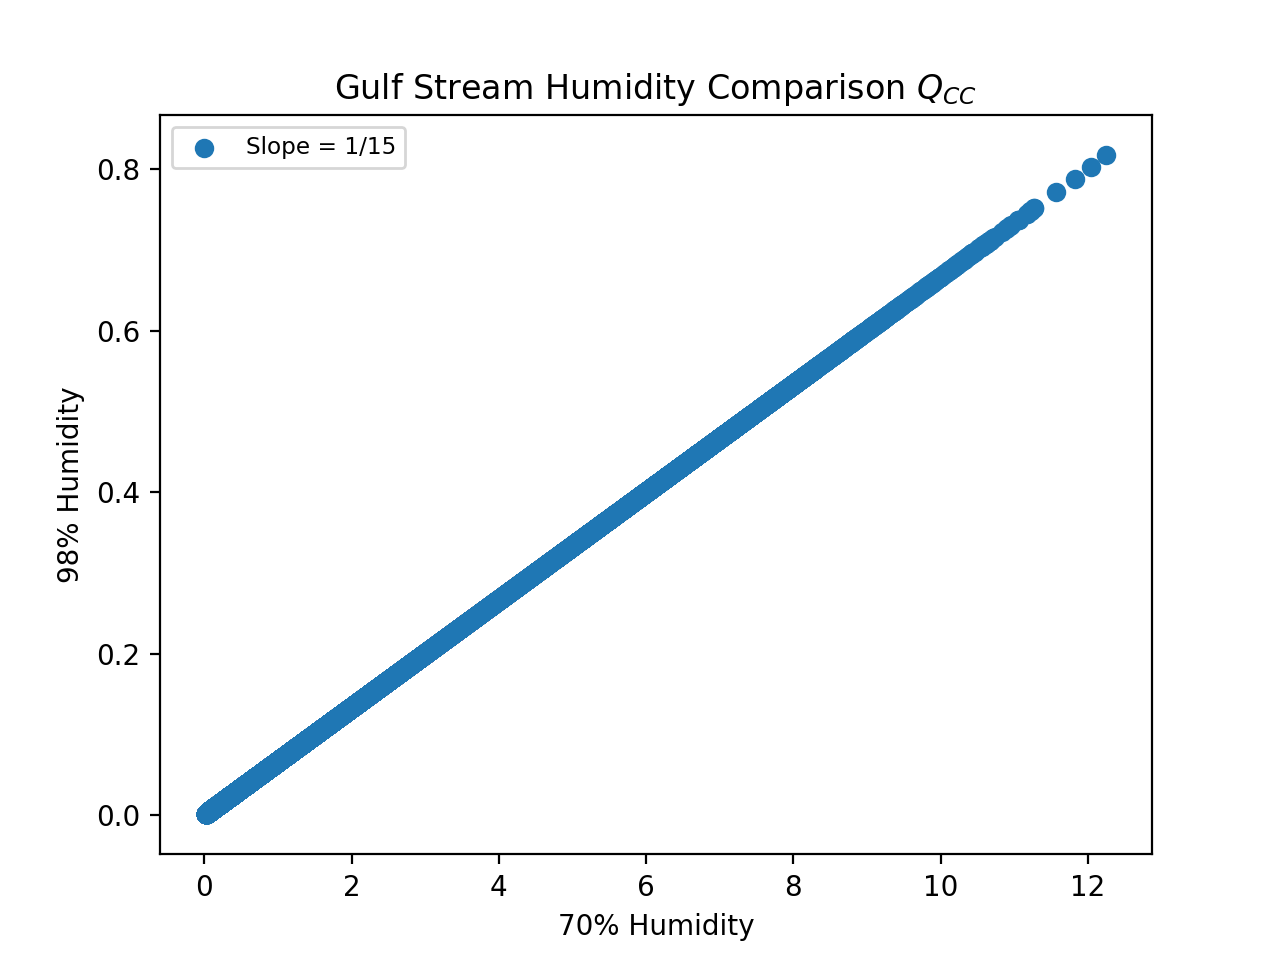

Text(0.5, 1.0, 'Gulf Stream Humidity Comparison $Q_{CC}$')

In [112]:
fig, ax = plt.subplots()
ax.scatter(np.ravel(Q4_70[0:300,:,:]),np.ravel(Q4_98[0:300,:,:]),label='Slope = 1/15')
#x = np.arange(0,14)
#ax.plot(x,x)

ax.legend(loc='upper left', fontsize='small', ncol=2)
ax.set_ylabel('98% Humidity')
ax.set_xlabel('70% Humidity')
ax.set_title("Gulf Stream Humidity Comparison $Q_{CC}$")

In [80]:
def makehistcount(varr,varh,br,bh):
    '''
    r will be y-axis and h will be x-axis
    br and bh is the box size of the histogram
    result counts the instances that data exists within the boxes
    '''

    
    #create "boxes" that sort our histogram and will be the x and y axis when we plot
    #r = np.arange(np.floor(np.nanmin(varr)),np.floor(np.nanmax(varr)),dr)
    r = np.linspace(np.nanmin(varr),np.nanmax(varr),br)
    dr = (np.nanmax(varr)-np.nanmin(varr))/br
    h = np.linspace(np.nanmin(varh),np.nanmax(varh),bh)
    dh = (np.nanmax(varh)-np.nanmin(varh))/bh
    
    #create resulting histogram matrix that will be plotted
    hist = np.zeros([len(r),len(h)],dtype=float)

    i = 0
    j = 0
    for i in range(len(r)):
        
        temp = varh[np.where((r[i] <= varr) & (r[i] + dr > varr))]
        
        for j in range(len(h)):
            
            hist[i,j] = np.count_nonzero((h[j] <= temp) & (h[j] + dh > temp))

    return r, h, hist


In [124]:
varr = Q5_19 #y-axis
varh = Q5_98 #x-axis

r, h, hist = makehistcount(varr,varh,120,80)

/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


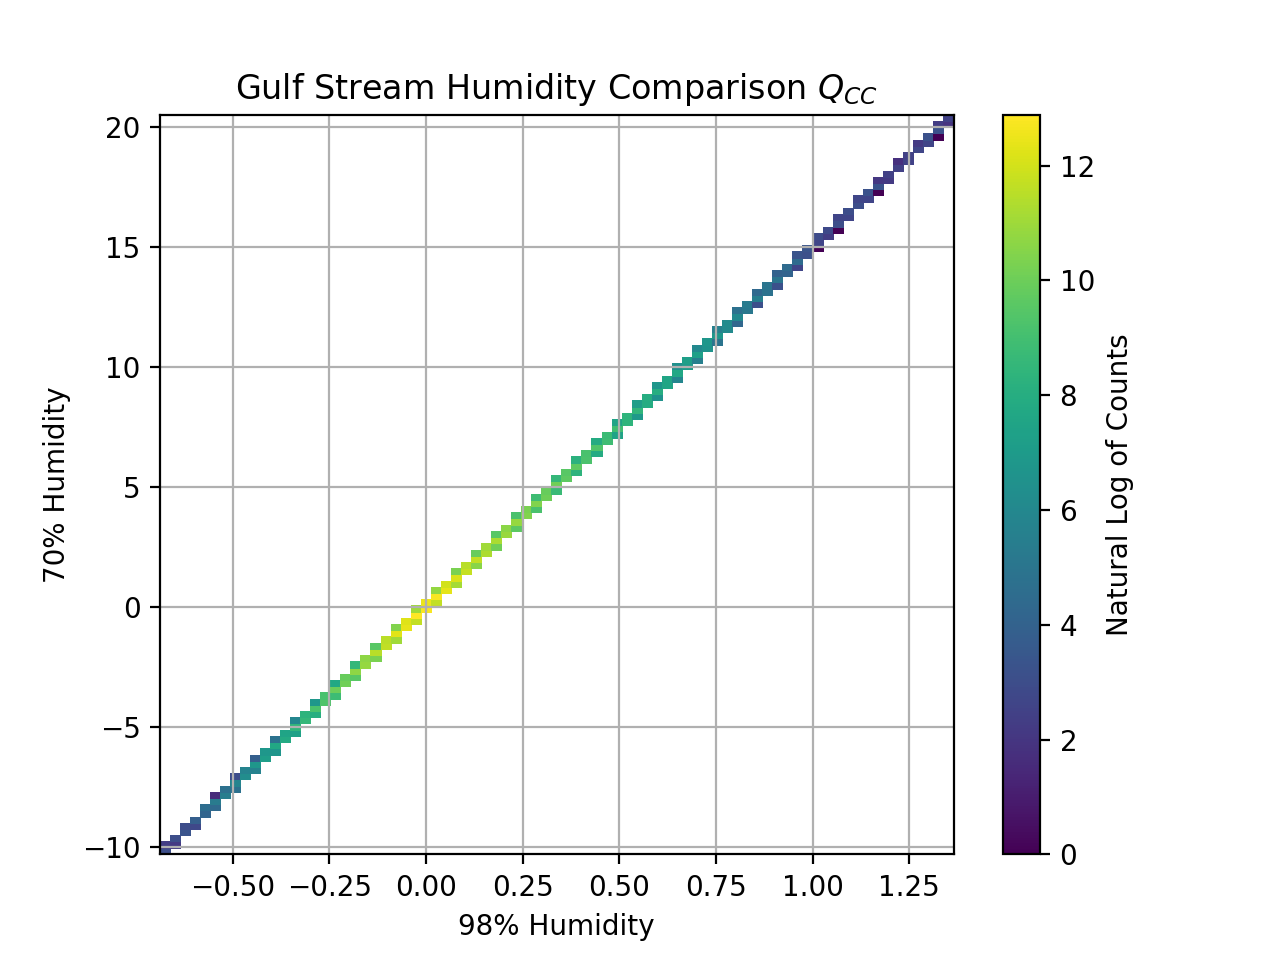

In [126]:
fig, ax = plt.subplots()

hist[np.where(hist == 0.0)] = None

pc = ax.pcolormesh(h,r,np.log(hist),label='dont')
fig.colorbar(pc,ax=ax,label="Natural Log of Counts")
x = np.arange(0,1)
#ax.legend(loc='upper right', fontsize='x-small', ncol=2)
ax.plot(x,x,'b')

ax.set_xlabel("98% Humidity")
ax.set_ylabel("70% Humidity")
ax.set_title("Gulf Stream Humidity Comparison $Q_{CC}$")
#plt.xticks(rotation = 10)
ax.grid()

In [127]:
plt.savefig('qut_humidity_slope15_GS.png', dpi=300, bbox_inches='tight')


# Things to Consider

- Use of WspdA over WspdD or an average of the two (averaging will weaken the signal)
- Use of 0.7*qs = qa
- What size N to use
- What space to choose for WBC or ERR (eddy rich region)
- Colorscale for plots
- Compare different seasons/time of year
- contour the continents with a black line
- subtract 20 from all temp, so you would expect the slope of CC to change, lower temps will have a smaller slope
- experiment with gaussian filter instead of top hat
- check possible smoothing errors: 